# Blockbusters actors : Analysis of the evolution of actors careers post-blockbuster in the film industry


##  Context

Analyze career trajectories of actors following their roles in high-grossing films using the CMU Movie Dataset.

More specifically, explore the following research questions: 
- Does a high-grossing film consistently lead to **continued box office success** for its actors in their subsequent films?
- Is there a noticeable **change in movie genre or type of characters** portrayed by actors after their first significant hit?
- What are **significant features** from actors who have starred in blockbuster hits compared to less well-known actors?

In this notebook, we will first start by loading CMU Movies data, then include the external IMDb dataset and finish by inspecting the useful data to answer our problematic.

# Table of Contents
- 1. [Data Preprocessing](#data)
    - [Loading existent data](#b)
    - [Data examination and filtering](#c)
        - [Feature selection](#d)
        - [Amount of data](#e)
    - [IMDb dataset integration](#f)
- 2. [Matching](#g)
    - [Blockbuster movies definition](#h)
    - [Blockbuster movies definition](#i)
    - [Data Matching](#j)
- 3. [Natural Language Processing](#k)
    - [Summaries extraction](#l)
    - [Impact of a Hoit Film on an Actor's role selection](#m)
- 4. [Analysis](#n)
    - [Big hit vs Non Big hit actors](#o)
        - [Carrer Longevity](#p)
        - [Movie counts](#q)
        - [Age at peak](#r)
    - [Carrer Post big hit analysis](#s)
        - [Revenue](#t)
        - [Average IMDb rating](#u)
        - [Success](#v)
        - [Genres](#w)
        - [Role](#x)














In [3]:
# Useful imports
import gzip
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import nltk
import os
import pandas as pd
import seaborn as sns
import shutil
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import xml.etree.ElementTree as ET
import scipy
from collections import Counter


from helpers import parse_genres, center_on_first_hit, similarity_two_prev_movie, similarity_two_prev_comp



<a id="data"></a>
##  1. Data Preprocessing



### 1.1 Loading Existent Data


We start by loading the data from the CMU Movies dataset into two pandas dataframe
- characters: dataframe containing information about actors and their associated movie characters
- movies: dataframe containing information about movies

In [4]:
# Define data paths
DATA_FOLDER = './MovieSummaries'
CHARACTER_DATASET = DATA_FOLDER + '/character.metadata.tsv'
MOVIE_DATASET = DATA_FOLDER + '/movie.metadata.tsv'
NAME_DATASET = DATA_FOLDER + '/name.clusters.txt'
PLOT_DATASET = DATA_FOLDER + '/plot_summaries.txt'
TVTROPES_DATASET = DATA_FOLDER + '/tvtropes.clusters.txt'

# Define column names
characters_columns = ['wikiID', 'movieID', 'releaseDate', 'charactName', 'birth', 'gender', 'height', 'ethnicity',
                      'name_actor', 'age', 'charActID', 'charID', 'actID']
movies_columns = ['wikiID', 'movieID', 'name_movie', 'releaseDate', 'revenue', 'runtime', 'languages',
                  'countries', 'genres']

# Load  data as pandas dataframes
characters = pd.read_table(CHARACTER_DATASET, header=None, names=characters_columns)
movies = pd.read_table(MOVIE_DATASET, header=None, names=movies_columns)

In [5]:
# Visualize characters data table
characters.head()

,wikiID,movieID,releaseDate,charactName,birth,gender,height,ethnicity,name_actor,age,charActID,charID,actID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [6]:
# Visualize movies data table
movies.head()

,wikiID,movieID,name_movie,releaseDate,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"



### 1.2 Data Examination and Filtering

With such a large database, it is complex to find a model that both describes the career of an English celebrity in the 40's and that of an actor in Japan in the 2000's. Cultural and economical differences also make it difficult to find a common metric for success. Therefore, we would like to limit ourselves to a consistent and comprehensible subset of the data.

#### 1.2.1 Feature Selection

In order to restrain our dataset to relevant aspects for our analysis, we select certain features from the database. The notion of success of an actor (detailed later in "Matching" section) depends on the number of movies they played in and their corresponding box office revenue. We're also interested in time features, to compare and describe timelines in the careers of actors. Finally, we'd like to have general information about the actors such as age, gender and ethnicity to mitigate a possible bias comming from a diffence in population distribution in our analysis

Thus, the **selected features** are:
* Actor name
* Actor date of birth or age at the time of the movie
* Actor gender
* Actor ethnicity
* Movie box office revenue
* Movie release date

In [7]:
# Make deep copies to preserve original data
characters_copy = characters.copy()
movies_copy = movies.copy()

We'll merge our dataframes to work on a single subset of data. As we're interested in actors careers, we decide to populate the characters dataframe with information on the movies in which they appear. For this, we perfom a left merge on characters_copy with movies_copy

In [8]:
# Left merge on characters dataframe with movies dataframe
character_movies = pd.merge(characters_copy, movies_copy, on=['wikiID', 'movieID', 'releaseDate'] , how='left')

#### 1.2.2 Amount of data

We'll now look at the **amount of information** available for each feature.

##### A. Movie revenue and date
Let's first look at the amount of data on **movie revenue** and **movie date** that is missing. We'll keep in mind that a movie can appear multiple times in this dataframe - we can have data about two different actors that appeared in the same movie.

In [9]:
# Compute the total number of movies
nb_movies = len(character_movies['movieID'].unique())

# Compute the number of movies for which we have "box office revenue"
character_movies_revenue = character_movies[['movieID', 'revenue']]
character_movies_revenue = character_movies_revenue.dropna()
nb_movies_revenue = len(character_movies_revenue['movieID'].unique())

# Compute the number of movies for which we have "release date"
character_movies_date = character_movies[['movieID', 'releaseDate']]
character_movies_date = character_movies_date.dropna()
nb_movies_date = len(character_movies_date['movieID'].unique())

# Print the results
print(f"The total number of movies we have is: {nb_movies}")
print(f"The percentage of movies for which we have the revenue: {nb_movies_revenue/nb_movies*100 :.2f}%")
print(f"The percentage of movies for which we have the release date: {nb_movies_date/nb_movies*100 :.5f}%")

The total number of movies we have is: 64330
The percentage of movies for which we have the revenue: 12.78%
The percentage of movies for which we have the release date: 94.23753%


We can observe that:
- most movies have a release date
- but only about 13% have information about the box office revenue

##### B. Percentage per year
Let's look at this **percentage per year** (with a temporal axis)

In [10]:
from helpers import complete_date

# Make deep copy and keep only the movies for which we have the release date
character_movies_filtered = character_movies.copy()
character_movies_filtered = character_movies_filtered.dropna(subset=['releaseDate'])

# Apply complete_date function to all release dates
character_movies_filtered['releaseDate'] = character_movies_filtered['releaseDate'].apply(complete_date)

# Convert to datetime format
character_movies_filtered['releaseDate'] = pd.to_datetime(character_movies_filtered['releaseDate'], errors='coerce')

# Add a column with the year of the release date
character_movies_filtered['year'] = character_movies_filtered['releaseDate'].dt.year

# Count the number of movies per 10 years interval
    # For the total number of movies
intervals = pd.cut(character_movies_filtered['year'], bins=range(1880, 2016, 10), right=False)
nb_movies_per_interval = intervals.value_counts().sort_index()

    # For movies with the revenue
character_movies_filtered_revenue = character_movies_filtered.dropna(subset=['revenue'])
intervals_revenue = pd.cut(character_movies_filtered_revenue['year'], bins=range(1880, 2016, 10), right=False)
nb_movies_per_interval_revenue = intervals_revenue.value_counts().sort_index()

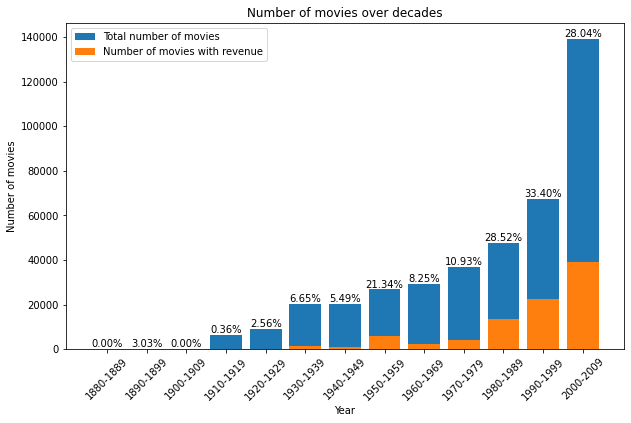

In [11]:
plt.figure(figsize=(10, 6))

# Plot bar plot of number of movies per year
tot_bar=plt.bar([f'{b.left}-{b.right-1}' for b in nb_movies_per_interval.index], 
                nb_movies_per_interval.values, label='Total number of movies')
revenue_bar=plt.bar([f'{b.left}-{b.right-1}' for b in nb_movies_per_interval_revenue.index],
                    nb_movies_per_interval_revenue.values, label='Number of movies with revenue')

plt.title('Number of movies over decades')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.tick_params(axis='x', rotation=45)
plt.legend()

# Add the percentage on top of each bar
for i, tot_bar in enumerate(tot_bar):
    height_tot_bar = tot_bar.get_height()
    height_revenue_bar = revenue_bar[i].get_height()
    percent = height_revenue_bar/height_tot_bar *100
    plt.text(tot_bar.get_x() + tot_bar.get_width() / 2, height_tot_bar + 5, 
             f'{percent:.2f}%', ha='center', va='bottom')

# Show graph
plt.show()

The percentage of revenue data increases through the year. It might be more relevant to perform our analysis on a subset of the years for which the revenue information is more present, therefore we decide to take **movies starting from 1950**.

In [12]:
# Remove all movies that where released before 1950
character_movies_filtered = character_movies_filtered[character_movies_filtered.year >= 1950]

# Look at the percentage of revenue data in this subset:
# Compute the total number of movies
nb_movies_selec = len(character_movies_filtered['movieID'].unique())

# Compute the number of movies for which we box office revenue
character_movies_filtered_revenue_selec = character_movies_filtered[['movieID', 'revenue']]
character_movies_filtered_revenue_selec = character_movies_filtered_revenue_selec.dropna()
nb_movies_selec_revenue = len(character_movies_filtered_revenue_selec['movieID'].unique())

print(f"The percentage of movies for which we have the revenue after 1950: {nb_movies_selec_revenue/nb_movies_selec*100 :.2f}%")

The percentage of movies for which we have the revenue after 1950: 15.99%


##### C. Percentage per country
Let's have a look at the **amount of revenue data per country**. We aggregate our data to obtain a dataframe counting the number of movies with known revenue per country, keeping countries that shot at least 200 movies.

In [13]:
from helpers import sort_words, create_words_database
# Make deep copy for the country analysis
df_country = character_movies_filtered.copy()

# Change countries into a list of String
df_country['countries'] = df_country['countries'].str.extract(r'\"([\w\s]+)\"')
df_country['countries'] = df_country['countries'].apply(lambda x: [x] if pd.notna(x) else ['Unknown'])

# Count the number of movies per country
countries_list = df_country['countries'].tolist()
# Flaten the list of countries and sort the resulting list
stored_countries = sort_words(countries_list)
# Count the number of repetition per country
nb_movies_per_country = create_words_database(stored_countries)
# Sort by ascending order of movies made per country
nb_movies_per_country = dict(sorted(nb_movies_per_country.items(), key=lambda item: item[1]))
# Remove countries that shot less than 200 movies
nb_movies_per_country = {country: nb for country, nb in nb_movies_per_country.items() if nb >= 200}


# Count the number of movies with known revenue per country
countries_list = df_country.dropna(subset=['revenue'])['countries'].tolist()
# Flaten the list of countries and sort the resulting list
stored_countries = sort_words(countries_list)
# Count the number of repetition per country
nb_movies_per_country_revenue = create_words_database(stored_countries)
# Sort by ascending order of movies made per country
nb_movies_per_country_revenue = dict(sorted(nb_movies_per_country_revenue.items(), key=lambda item: item[1]))


# Keep countries with more than 200 movies and add to nb_movies_per_country_revenue countries without revenue data (set their number of movies to zero)
country_200_movie = list(nb_movies_per_country.keys())
nb_movies_per_country_revenue = {country: nb for country, nb in nb_movies_per_country_revenue.items() if country in country_200_movie}
nb_movies_per_country_revenue.update({country: 0 for country in country_200_movie if country not in nb_movies_per_country_revenue})
nb_movies_per_country_revenue = {country: nb_movies_per_country_revenue[country] for country in nb_movies_per_country}

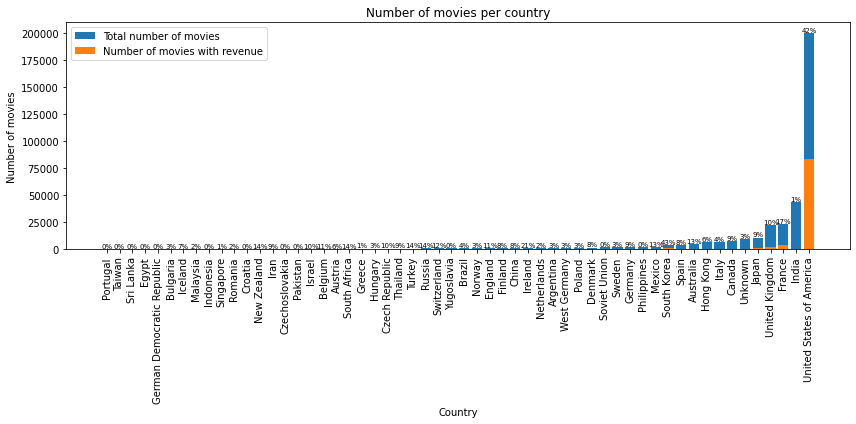

In [14]:
# Extract the names of the countries and the value from each dictionary
country_names = list(nb_movies_per_country.keys())
nb_movies_tot = list(nb_movies_per_country.values())
nb_movies_revenue = list(nb_movies_per_country_revenue.values())

# Make a list of indices for the position of the bars
indices = range(len(country_names))

# Plot histogram
plt.figure(figsize=(12, 6))
bars_tot = plt.bar(indices, nb_movies_tot, label='Total number of movies')
bars_revenue = plt.bar(indices, nb_movies_revenue, label='Number of movies with revenue')

# Add label and title
plt.xlabel('Country')
plt.ylabel('Number of movies')
plt.title('Number of movies per country')
plt.xticks(indices, country_names, rotation=90)

# Add the percentage on top of each bar
for i, bars_tot in enumerate(bars_tot):
    height_bars_tot = bars_tot.get_height()
    height_bars_revenue = bars_revenue[i].get_height()
    percent = height_bars_revenue/height_bars_tot *100
    plt.text(bars_tot.get_x() + bars_tot.get_width() / 2, height_bars_tot + 5,
             f'{percent:.0f}%', ha='center', va='bottom', size=7)


# Show legend and histogram
plt.legend()
plt.tight_layout()
plt.show()

From this plot we can see that the majority of the movies in our dataset come from the U.S. and have a high percentage of revenue information. From this we decided to keep only **movies that were made in the U.S.**

In [15]:
# Keep only movies that where made in the U.S.
character_movies_filtered = character_movies_filtered[
    character_movies_filtered.countries.apply(lambda x:"United States of America" in x)]

# Keep only movies for which we have the revenue
character_movies_filtered = character_movies_filtered.dropna(subset=['revenue'])

# Compute the number of movies left
nb_tot_filtered_movies = len(character_movies_filtered['movieID'].unique())

print(f'The remaining number of movies after the filtration is: {nb_tot_filtered_movies}.')

The remaining number of movies after the filtration is: 6520.


Now that we have filtered our data to have only **U.S. movies which where released after and including the year 1950** and that have the revenue data, we'll look at the data from the actors.

#### D. Data from actors

We'll look at the amount of data available for the following actors features:
- Name
- Date of birth
- Age
- Gender
- Ethnicity

In [16]:
# Compute the total number of characters and actors
nb_actors = len(character_movies_filtered['name_actor'].unique())

# Compute the number of actors for which we have the name
character_movies_name = character_movies_filtered[['name_actor']]
character_movies_name = character_movies_name.dropna()
nb_actors_name = len(character_movies_name['name_actor'].unique())

# Compute the number of actors for which we have the date of birth
character_movies_birth = character_movies_filtered[['birth', 'name_actor']]
character_movies_birth = character_movies_birth.dropna()
nb_actors_birth = len(character_movies_birth['name_actor'].unique())

# Computer the number of actors for which we have the age (positive number)
character_movies_age = character_movies_filtered[['age', 'name_actor']]
character_movies_age = character_movies_age.dropna()
character_movies_age = character_movies_age[character_movies_age.age>=0]
nb_actors_age = len(character_movies_age['name_actor'].unique())

# Compute the number of actors for which we have the gender
character_movies_gender = character_movies_filtered[['gender', 'name_actor']]
character_movies_gender = character_movies_gender.dropna()
nb_actors_gender = len(character_movies_gender['name_actor'].unique())


# Compute the number of actors for which we have the ethnicity
character_movies_ethnicity = character_movies_filtered[['ethnicity', 'name_actor']]
character_movies_ethnicity = character_movies_ethnicity.dropna()
nb_actors_ethnicity = len(character_movies_ethnicity['name_actor'].unique())

# Print the results
print(f"The total number of actors we have is: {nb_actors}")
print(f"The percentage of actors for which we have the name is: {nb_actors_name/nb_actors*100 :.5f}")
print(f"The percentage of actors for which we have the birth date is: {nb_actors_birth/nb_actors*100 :.2f}")
print(f"The percentage of actors for which we have the age is: {nb_actors_age/nb_actors*100 :.2f}")
print(f"The percentage of actors for which we have the gender is: {nb_actors_gender/nb_actors*100 :.2f}")
print(f"The percentage of actors for which we have the ethnicity is: {nb_actors_ethnicity/nb_actors*100 :.2f}")

The total number of actors we have is: 29674
The percentage of actors for which we have the name is: 99.99663
The percentage of actors for which we have the birth date is: 63.55
The percentage of actors for which we have the age is: 61.42
The percentage of actors for which we have the gender is: 84.89
The percentage of actors for which we have the ethnicity is: 14.77


From this analysis we can see that we have enough information on the gender and on the age (esp. with birth date) of the actors. However ethnicity data is often missing. Thus, it might be good to **filter only for birth date and gender**.

In [17]:
# Filter for birth date
character_movies_filtered = character_movies_filtered.dropna(subset=['birth'])

# Apply complete_date function to all birth dates to format them
character_movies_filtered['birth'] = character_movies_filtered['birth'].apply(complete_date)
character_movies_filtered['birth'] = pd.to_datetime(character_movies_filtered['birth'], format='%Y-%m-%d', errors='coerce')

# Get rid of aberrant age values of actors at movie release date
character_movies_filtered = character_movies_filtered[character_movies_filtered.birth.dt.year < character_movies_filtered.year]

# Filter for gender (NaN and aberrant values)
character_movies_filtered = character_movies_filtered.dropna(subset=['gender'])
character_movies_filtered = character_movies_filtered[
    (character_movies_filtered.gender=='F') | (character_movies_filtered.gender=='M')]

# Compute the remaining number of actors and movies
nb_tot_filtered_movies = len(character_movies_filtered['movieID'].unique())
nb_tot_filtered_actors = len(character_movies_filtered['name_actor'].unique())

print(f'The remaining number of movies is: {nb_tot_filtered_movies}.')
print(f'The remaining number of actors is: {nb_tot_filtered_actors}.')

The remaining number of movies is: 6495.
The remaining number of actors is: 18633.


##### E. Number of movies

Now that we have reduced our dataset to this smaller subset we can see that data handling will not be a problem. Finally we'll look at the distribution of the number of movies played by actor.

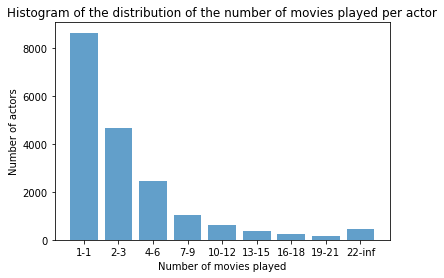

In [18]:
# List all actors name (for filtered data)
actors_names = character_movies_filtered['name_actor'].tolist()

#count the repertition number of each actor name
nb_mov_actor = create_words_database(sorted(actors_names))

# Sort the actors by ascending order of movies played
nb_mov_actor = dict(sorted(nb_mov_actor.items(), key=lambda item: item[1]))

# Define intervals
intervals = [1, 3, 6, 9, 12, 15, 18, 21]

# Initialize a dictionary to stock the number of actors in each interval
actors_per_interval = {i: 0 for i in range(len(intervals) + 1)}

# Count the number of actors in each interval
for actor, index in nb_mov_actor.items():
    for i, threshold in enumerate(intervals):
        if index <= threshold:
            actors_per_interval[i] += 1
            break
    else:
        actors_per_interval[len(intervals)] += 1

# Plot histogram
plt.bar(actors_per_interval.keys(), actors_per_interval.values(), align='center', alpha=0.7)
plt.xticks(list(actors_per_interval.keys()), [f"{i+1}-{j}" for i, j in zip([0] + intervals, intervals + [float('inf')])])
plt.xlabel('Number of movies played')
plt.ylabel("Number of actors")
plt.title('Histogram of the distribution of the number of movies played per actor')
plt.show()

From this histogram we see that many actors played in only one movie so we will further decrease the size of our dataset to only keep actors that played in **at least two movies**.

In [19]:
from helpers import at_least_2_movies

# Apply filtering function to actor dictionary
filtered_actors = dict(filter(at_least_2_movies, nb_mov_actor.items()))

# Filter dataset
character_movies_filtered = character_movies_filtered[character_movies_filtered['name_actor'].isin(filtered_actors.keys())]

# Compute the remaining number of actors and movies
nb_tot_filtered_movies = len(character_movies_filtered['movieID'].unique())
nb_tot_filtered_actors = len(character_movies_filtered['name_actor'].unique())

print(f'The remaining number of movies is: {nb_tot_filtered_movies}.')
print(f'The remaining number of actors is: {nb_tot_filtered_actors}.')

The remaining number of movies is: 6443.
The remaining number of actors is: 10001.


### 1.3  IMDb dataset integration

For further analysis, we'll have to define the notion of success of a movie. For this purpose, we decide to include a measure of public satisfaction given by the IMDb ratings. IMDb is a popular source for movies, TV shows and celebrity content where users can cast a vote from 1 to 10 on every released title in the database.

In this part we will take care of loading this new dataset and merging it with our filtered dataset ('character_movies_filtered')
- IMDb_ratings: dataframe of ratings
- IMDb_basics: dataframe of information including the original name

Both datasets are linked by a constant ID 'tconst' that allows us to merge them into a single dataframe.

In [20]:
# Load IMDb datasets into pandas dataframes
IMDb_ratings = pd.read_table(DATA_FOLDER + '/title.ratings.tsv.gz')
IMDb_basics = pd.read_table(DATA_FOLDER +  '/title.basics.tsv.gz')

# Merge ratings with names
IMDb = pd.merge(IMDb_ratings, IMDb_basics, on='tconst')

/var/folders/f0/cfcxfzqn0nv2yms8q65vtvc80000gn/T/ipykernel_52912/3889453638.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDb_basics = pd.read_table(DATA_FOLDER +  '/title.basics.tsv.gz')


We will now merge the IMDb dataframe with our filtered dataframe 'character_movies_filtered'. As there is no direct ID linking these datasets, we will merge them on the movie name. To ensure that we avoid merging movies having the same name, we'll also merge on the release date of the movie. Let's first store in a list the movies for which we have the same name but different release date (e.g. Twilight).

In [21]:
# Get a list of the movie names (name_movie) for which we have multiple releaseDate values
subset = character_movies_filtered.drop_duplicates(subset = ['name_movie', 'releaseDate'])
grouped = subset.groupby('name_movie').releaseDate.count()
list_mlt_dates = list(grouped[grouped>1].index)

But by naively removing all movies that do not have a 'startYear' in the IMDb dataset we loose many movies that we could have merged using only the movie name.

Further more some movie names in the IMDb ratings have multiple ratings values (e.g. different versions). To deal with this we keep only the rating values for which we have the most votes. 

Then we set aside movies that have multiple year and merge them witht the IMDb ratings using the movie name and the release year. For the other movies we simply merged on the movie name. This allowed to reduce the loss of movies from ~10% to ~4.6%.

In [22]:
# For movies with multiple releaseDate: keep only movies with startYear (necessary for the upcoming merge)
IMDb_with_year = IMDb[IMDb.originalTitle.isin(list_mlt_dates)]
IMDb_with_year = IMDb_with_year.dropna(subset = 'startYear')
IMDb_with_year = IMDb_with_year[~(IMDb_with_year.startYear =='\\N')]

# Convert startYear from string to float (for upcoming merge)
IMDb_with_year.startYear = IMDb_with_year.startYear.astype(float)

# IMDb dataset with movies that do not have multiple releaseDate values of multiple IMDb ratings
IMDb = IMDb[~IMDb.originalTitle.isin(list_mlt_dates)]

# If multiple different averageRating for a same movie then keep the value with the most votes (numVotes)
IMDb_with_year = IMDb_with_year.sort_values(by='numVotes', ascending=False)
IMDb = IMDb.sort_values(by='numVotes', ascending=False)
IMDb_with_year = IMDb_with_year.drop_duplicates(subset=['originalTitle', 'startYear'] , keep='first')
IMDb = IMDb.drop_duplicates(subset='originalTitle' , keep='first')

In [23]:
# Keep only the desired columns
IMDb = IMDb[['originalTitle', 'averageRating']]
IMDb_with_year = IMDb_with_year[['originalTitle', 'averageRating', 'startYear']]

In [24]:
# Populate the characters - movies dataset with the IMDb ratings (movies with multiple averageRating of releaseDate)
character_movies_filtered_imdb = pd.merge(character_movies_filtered, IMDb_with_year, how='left',
                                          left_on=['name_movie', 'year'], right_on=['originalTitle', 'startYear'])

# Remove unwanted columns (duplicated during merge)
character_movies_filtered_imdb = character_movies_filtered_imdb.drop(labels = ['originalTitle', 'startYear'], axis=1)

# Populate the characters - movies dataset with the IMDb ratings
character_movies_filtered_imdb = pd.merge(character_movies_filtered_imdb, IMDb, how='left',
                                          left_on='name_movie', right_on='originalTitle')

# Combine the two averageRating we got from the merges (replace the null NaN from one column with values form the other)
character_movies_filtered_imdb['averageRating'] = character_movies_filtered_imdb.averageRating_x.combine_first(character_movies_filtered_imdb.averageRating_y)
character_movies_filtered_imdb = character_movies_filtered_imdb.drop(labels = ['originalTitle', 'averageRating_x', 'averageRating_y'], axis=1)

Now we filter our merged dataframe to keep only movies for which we have the IMDb rating. We can then evalutate the number and the impact of the lost movies during this operation.

In [25]:
# Filter for entries that have IMDb ratings
character_movies_filtered_imdb = character_movies_filtered_imdb.dropna(subset = 'averageRating')

# Look at the movie loss from the IMDb merge
lost_movies = len(character_movies_filtered.movieID.unique()) - len(character_movies_filtered_imdb.movieID.unique())

print(f'The number of movies that we lost by adding the IMDb ratings is: {lost_movies}. \
This represents a loss of {lost_movies*100/len(character_movies_filtered.movieID.unique()): .2f}%')

The number of movies that we lost by adding the IMDb ratings is: 299. This represents a loss of  4.64%


As we can see the loss is only of 4.64% so it is reasonable and we will carry on with our new dataframe.

## 2. Matching

This section is dedicated to the matching part of the project. Performing matching before an observational study is essential to reduce confounding variables and create balanced treatment and control groups, enhancing the study's internal validity. By ensuring comparability, matching improves the precision of estimates and strengthens the credibility of observed treatment effects. 

### 2.1 Blockbuster movies definition

We'll start by defining what makes a movie a big hit (blockbuster). We'll focus on the revenue as mentioned earlier, but also include the IMDb ratings.

We first copy the main dataframe 

In [26]:
# Make deep copy of our prepared dataset
df_prepared = character_movies_filtered_imdb.copy()

We define the metric for the **success of a movie** as the product of the revenue and the average rating.

In [27]:
# Add a column to our dataset for this new success metric
df_prepared['success'] = df_prepared.revenue * df_prepared.averageRating

We'll examine the **evolution of this metric along the years**.

[]

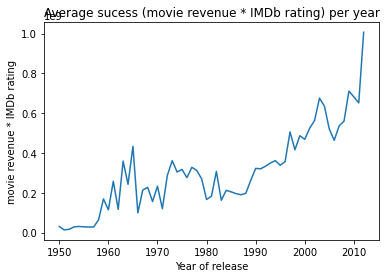

In [28]:
# Drop duplicate movies
unique_movies = df_prepared.drop_duplicates(subset = 'movieID')

# Group by year and success
success_per_year = unique_movies.groupby(by = 'year')['success']

# Get the mean and standard deviation of the success metric for each year
avg_success_per_year = success_per_year.mean()
std_success_per_year = success_per_year.std()

# Plot the results
plt.plot(avg_success_per_year)
plt.title('Average sucess (movie revenue * IMDb rating) per year')
plt.ylabel('movie revenue * IMDb rating')
plt.xlabel('Year of release')
plt.plot()

From this graph we can see a certain fluctuation in the average movie revenue per year.

We'll assume that for a movie to be a big hit it, has to be an **outlier** with respect to our previously defined success metric (product of revenue and average rating). The outliers of each year will be labelled as big hits.

We define an outlier as: 

*outlier's success metric > Q3 + 1.5(IQR)*

where Q1, Q3 and IQR are respectively the first quantile, the third quantile and the interquantile range.

The number of big hits is: 653


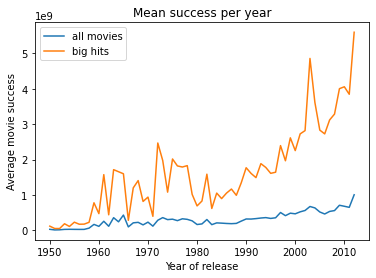

In [29]:
# Compute the first and the third quantile for each year
Q1 = success_per_year.quantile(q=0.25)
Q3 = success_per_year.quantile(q=0.75)

# Compute our ouliner threshold value for each year
outlier_thresh = Q3 + 1.5 *(Q3-Q1)
outlier_thresh.name = 'threshold'

# Filter movie dataset to keep only the big hits
movies_merged = pd.merge(df_prepared, outlier_thresh, left_on='year', right_index=True)
big_hits = movies_merged[movies_merged['success'] > movies_merged['threshold']]

# Plot the mean revenue for big hits compaired to the mean revenue for all movies per year
unique_movie_hits = big_hits.drop_duplicates(subset = 'movieID')
success_hits_per_year = unique_movie_hits.groupby(by = 'year')['success'].mean()

plt.plot(avg_success_per_year, label = 'all movies')
plt.plot(success_hits_per_year, label = 'big hits')

# Add labels
plt.title('Mean success per year')
plt.ylabel('Average movie success')
plt.xlabel('Year of release')
plt.legend()
plt.plot()

# How many big hits do we have?
print(f'The number of big hits is: {len(unique_movie_hits)}')

We now divided our movie set between big hits and moderate success movies.

### 2.2 Blockbuster actors defintion

Let's divide our actors dataset into the ones that played in a big hit (treatement group) and the ones that did not (control group).

In [30]:
# Get a set with the names of the actors that played in a big hit
unique_actor_hits = big_hits.drop_duplicates(subset = 'name_actor').name_actor

# Creat a new column on our main dataframe, a bool for wheter the actors played in a big hit or not
df_prepared['big_hit_actor'] = df_prepared.name_actor.isin(unique_actor_hits)

# Get a dataframe of actors that played in a big hit (treatement group)
actors_big_hit = df_prepared[df_prepared.big_hit_actor]

# Get a dataframe of actors that did not play in a big hit (control group)
actors_no_big_hit = df_prepared[~df_prepared.big_hit_actor]

# Print the number of actors in each group
nb_big_hit_actors = len(unique_actor_hits)

print(f'The number of actors that played in a big hit is: {nb_big_hit_actors} (treatement group)')
print(f'The number of actors that did not play in a big hit is: {nb_tot_filtered_actors-nb_big_hit_actors} (control group)')

The number of actors that played in a big hit is: 4377 (treatement group)
The number of actors that did not play in a big hit is: 5624 (control group)


We now have our treatment and control groups. Let's look at the distribution of different features for which we have information.

##### A. Gender
We can first look at the distribution of gender along these 2 groups.

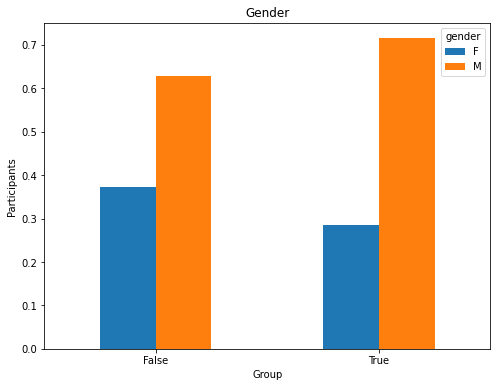

In [31]:
# Grouping the DataFrame 'df_prepared' by 'big_hit_actor' and 'gender', and counting occurrences of 'gender' within each group
group = df_prepared.groupby(['big_hit_actor', 'gender'])['gender'].count()

# Unstacking the grouped data to create a pivot table for easier plotting
group = group.unstack()

# Normalizing the data by dividing each row by the sum of its values to represent proportions
group = group.div(group.sum(axis=1), axis=0)

# Plotting a bar chart using the normalized data with specific formatting
pl = group.plot(kind='bar', figsize=[8,6], rot=0)

pl.set_title('Gender')
pl.set_ylabel('Participants')
pl.set_xlabel('Group')
plt.show()


From this chart, we observe that:
- there are **more men than women** both in blockbusters and less popular movies
- the **difference is even bigger** in blockbusters

This means that gender could be a key factor to look at when studying the difference between actors in big hits and those in other movies.

##### B. Peak age

Now let's have look at the repartition of the **age at the peak of the actors career**.

We define the **peak of one actor's carrier** by the year where the product of the number of movies played in with their respective success metric is the highest.

/var/folders/f0/cfcxfzqn0nv2yms8q65vtvc80000gn/T/ipykernel_52912/2492928083.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='big_hit_actor', y='age_at_peak',


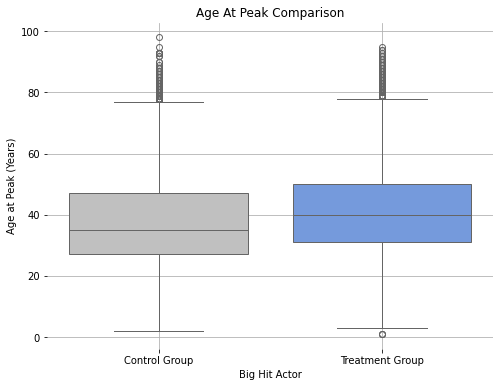

In [32]:
# Calculate the product of the number of movies and respective success metric for each actor and year
df_prepared['product'] = df_prepared.groupby(['name_actor', 'year']).movieID.transform('count') * df_prepared.success

# Find the row with the maximum product for each actor
max_product_rows = df_prepared.loc[df_prepared.groupby('name_actor')['product'].idxmax()]

# Extract the actor and the corresponding year for the maximum product
result = max_product_rows.loc[:, ['name_actor', 'year', 'birth']]

# Correcting the calculation of 'age_at_peak' and merging it into the df_prepared DataFrame
result['age_at_peak'] = result['year'] - result['birth'].dt.year
df_prepared = pd.merge(df_prepared, result[['name_actor', 'age_at_peak']], on='name_actor', how='left')

# Ensuring 'age_at_peak' is calculated correctly
df_prepared['age_at_peak'] = df_prepared['year'] - df_prepared['birth'].dt.year

# Set the figure size and style for better readability
plt.figure(figsize=(8, 6))

# Draw a nested boxplot to show career length by actor type
sns.boxplot(x='big_hit_actor', y='age_at_peak', 
            data=df_prepared, 
            palette=["silver", "cornflowerblue"])

# Customize the plot with titles and labels
plt.grid(True)
plt.title('Age At Peak Comparison')
plt.xlabel('Big Hit Actor')
plt.ylabel('Age at Peak (Years)')
plt.xticks([0, 1], ['Control Group', 'Treatment Group'])
# Remove the grid lines for a cleaner look
sns.despine(bottom=True, left=True)

# Show the plot
plt.show()

The boxplot shows that:
- actors in big hits usually hit their peak at an **older age** than those who do not star in big hits
- there are quite a few actors who peak at ages that are much higher or lower than average (outliers), especially among those without a big hit

In comparing successful actors from big hits to others, the age at which they peaked is an interesting factor to look at. However, we must be careful because actors from different times cannot be easily compared. Success and fame can look different across different eras, so comparing the career trajectories of actors who peaked at different times might not give us a clear picture. It's crucial to remember this when we're analyzing their careers. That's why we will not use age_at_peak for our matching but the age instead.

### 2.3 Data Matching

We will perform the matching on gender, age and the number of movies played in (this last matching variable will be further developed below).

##### A. First big hit

We will first find the **first big hit** of every blockbuster actor. To do this we filter the df_prepared dataframe to obtain all big hit actors with all their associated big hits. We then group the big hits of every blockbuster actor by year and select the first one.

In [33]:
# Remove duplicate rows (actors that had multiple roles in the same movie)
df_prepared = df_prepared.drop_duplicates(subset=['movieID', 'releaseDate', 'name_actor'])

# Define the condition for a movie to be a big hit
df_prepared['is_movie_big_hit'] = df_prepared.movieID.isin(unique_movie_hits.movieID)

# Filter for blockbuster actors and all of their associated big hits
big_hit_actors_df = df_prepared[df_prepared['big_hit_actor'] & df_prepared['is_movie_big_hit']]

# Find the year of the first big hit for each actor
first_big_hit_year = big_hit_actors_df.groupby('name_actor')['releaseDate'].min().reset_index()

# Merge the information back into the original DataFrame
df_prepared = pd.merge(df_prepared, first_big_hit_year, on='name_actor', how='left', suffixes=('', '_first_big_hit'))

##### B. Count of movies

We will now add the counts of movies an actor played in to our dataframe.

In [34]:
# Count the number of unique movies each actor has played in
movies_per_actor = df_prepared.groupby('name_actor')['movieID'].nunique()

# Convert the series to a dataframe and reset the index
movies_per_actor_df = movies_per_actor.reset_index()
movies_per_actor_df.columns = ['name_actor', 'movie_count']

# Merge with the main DataFrame to associate the movie count with the big_hit_actor bool
df_prepared = df_prepared.merge(movies_per_actor_df, on='name_actor')

##### C. Preparing matching data

We will now seperate our data into two distinct dataframes:
- a dataframe for the information about age, gender and movie counts for actors that played in big hits (treatment group)
- a dataframe for the information about age, gender and movie counts for the rest of the actors (control group)

In [35]:
# Create a new DataFrame for big hit actors 
big_hit_actors = df_prepared[df_prepared['big_hit_actor'] == True]

# Group by actor's name and calculate movie count before first big hit
movie_count_before_hit = big_hit_actors.groupby('name_actor').apply(lambda x: x[x['releaseDate'] < x['releaseDate_first_big_hit']]['movieID'].nunique())

# Convert the Series to a DataFrame and reset index
movie_count_before_hit = movie_count_before_hit.reset_index(name='movie_count_before_hit')

# Merge this count back into the original DataFrame
df_prepared = pd.merge(df_prepared, movie_count_before_hit, on='name_actor', how='left')

# Set the count to NaN for actors who are not big hit actors
df_prepared.loc[df_prepared['big_hit_actor'] == False, 'movie_count_before_hit'] = np.nan

# Create a new DataFrame from the drop_duplicates result
unique_actors = df_prepared.drop_duplicates(subset='name_actor').copy()

# Convert the 'big_hit_actor' column to int
unique_actors['big_hit_actor'] = unique_actors['big_hit_actor'].astype(int)

# Calculate the movie count afte hit
unique_actors['movie_count_after_hit'] = unique_actors['movie_count'] - unique_actors['movie_count_before_hit']

actors_big_hit = unique_actors[unique_actors['big_hit_actor'] == 1][['age_at_peak', 'gender', 'movie_count_before_hit', 'movie_count_after_hit']]

# Get a dataframe of actors that did not play in a big hit (control group)
actors_no_big_hit = unique_actors[unique_actors['big_hit_actor'] == 0][['age_at_peak', 'gender', 'movie_count']]

##### D. Perform matching

Now that we have the dataframes containing the information about age, gender and movie counts for actors in both groups, we can perform the **matching** between these two groups.

In [36]:
# Threshold for the condition to add an edge between treatment and control nodes
# To be able to compare control and treatment group, we need to satify these two conditions:
# 1. contro[movie_count] - treat[movie_before_hit] >=3
# 2. treat[movie_after_hit] >=3
# These conditions will allow us to compare the carrer after and post big hit
th = 3

# Drop all big hit actor with less than 3 movies after the big hit
actors_big_hit = actors_big_hit[actors_big_hit['movie_count_after_hit']>=3]

# Resetting the index of the DataFrame 'actors_big_hit' and converting it to a NumPy array
actors_big_hit = actors_big_hit.reset_index()
actors_big_hit_numpy = actors_big_hit.to_numpy()

# Extracting treatment indices from the NumPy array
treat_indices = actors_big_hit_numpy[:, 0]

# Resetting the index of the DataFrame 'actors_no_big_hit' and converting it to a NumPy array
actors_no_big_hit = actors_no_big_hit.reset_index()
actors_no_big_hit_numpy = actors_no_big_hit.to_numpy()

# Extracting control indices from the NumPy array
control_indices = actors_no_big_hit_numpy[:, 0]

# Creating an empty graph using NetworkX
B = nx.Graph()

# Adding nodes for the treatment group to the graph
B.add_nodes_from(treat_indices, bipartite=0)

# Adding nodes for the control group to the graph
B.add_nodes_from(control_indices, bipartite=1)


# Iterating over rows in the treatment and control groups to add edges based on specified conditions
for t_row in actors_big_hit_numpy:
    for c_row in actors_no_big_hit_numpy:
        if abs(t_row[1] - c_row[1]) <= 10 and t_row[2] == c_row[2] and c_row[3] - t_row[3] >= th:
            # Adding an edge between treatment and control nodes with the total cost as weight
            B.add_edge(t_row[0], c_row[0], weight=0)

# Finding the minimum weight matching in the bipartite graph using NetworkX
matching = nx.algorithms.matching.min_weight_matching(B)

In [37]:
print(f'The number of match is: {len(matching)}')

The number of match is: 2794


We will store the values from the matching in a dataframe matched_df to analyse it

In [38]:
# Creating a new DataFrame to store the matched pairs with names
matched_df = pd.DataFrame(columns=['control_index', 'name_actor_control', 'treat_index', 'name_actor_treat'])

for control_idx, treatment_idx in matching:
    control_name = unique_actors.loc[control_idx]['name_actor']
    treatment_name = unique_actors.loc[treatment_idx]['name_actor']
    new_row = pd.DataFrame({
        'control_index': control_idx,
        'name_actor_control': control_name,
        'treat_index': treatment_idx,
        'name_actor_treat': treatment_name
    }, index=[0])
    matched_df = pd.concat([matched_df, new_row], axis=0, ignore_index=True)

matched_df

,control_index,name_actor_control,treat_index,name_actor_treat
0,49152,Joanna Going,28731,Susan Sarandon
1,17241,Tristan Wilds,47670,Walton Goggins
2,56656,Paul Richards,9283,Roger L. Jackson
3,25034,Seymour Cassel,56698,Peter Gerety
4,52517,Eva Longoria,57046,Sasha Alexander
...,...,...,...,...
2789,46097,Alec McCowen,49425,Wally George
2790,23317,Ashley Tisdale,39559,Daliah Lavi
2791,19352,Lea Thompson,45745,Patty Hearst
2792,31683,Matt Frewer,41655,Abner Biberman


Finally, we will selecting the rows from 'unique_actors' based on the matched indices

In [39]:
# Extracting the matched indices from the minimum weight matching and combining them into a list
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

# Creating a new DataFrame 'balanced_df' by selecting rows from 'unique_actors' based on the matched indices
balanced_df = unique_actors.loc[matched]

The values from the matching will be stored in order to be accessible in other notebooks.

## 3. Natural Language Processing

In [40]:
df_prepared_copie = character_movies_filtered_imdb.copy()
liste_wikiID_uniques = df_prepared_copie['wikiID'].unique()
# display(df_prepared)

### 3.1 Summaries extraction


Our primary dataset consists of 42,306 movie plot summaries from the English Wikipedia.
These summaries briefly describe the movie plots and include character descriptions. To analyze this data, we used the preexisting Stanford CoreNLP preprocessed summaries. Those files were already tagged, parsed and each token was already associated with its proper Named Entity and coreference. 
After converting the data from XML files to a structured format, we will be able to extract specific linguistic characteristics associated with each character of the movies that we filtered.

In [41]:
# Home directory
source_directory = 'corenlp_plot_summaries'

# Destination directory for files corresponding to wikiIDs
destination_directory = 'MovieSummaries/tried_summaries'

# Directory creation
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Get a list of files in the source directory
source_files = os.listdir(source_directory)

# Loop through the files in the source directory
for files in tqdm(source_files):
    # Checks if the file matches a wikiID in the list
    wikiID = files.replace('.xml.gz', '')
    if int(wikiID) in liste_wikiID_uniques:
        # Build complete source and destination file paths
        source_path = os.path.join(source_directory, files)
        destination_path = os.path.join(destination_directory, f"{wikiID}.txt.xml")

        # Unzip the gzip file
        with gzip.open(source_path, 'rt', encoding='utf-8') as f_in:
            # Copy the contents to a .txt.xml file in the new directory
            with open(destination_path, 'w', encoding='utf-8') as f_out:
                shutil.copyfileobj(f_in, f_out)

print("Extraction complete.")
# print(len(os.listdir(destination_directory)))

  0%|          | 0/42306 [00:00<?, ?it/s]

100%|██████████| 42306/42306 [01:13<00:00, 572.50it/s] 

Extraction complete.


### 3.2 Impact of a Hit Film on an Actor's role selection

#### PART 1: Analysis of Character Appearances in Plot Summaries
Analysis of plot summaries: We will extract the mentioned characters, that is, the names of characters repeated in synopsis (entities labeled as PERSON), and we will determine the percentage of repetition for each name.

#### PART 2: Defining Actor Roles Based on Their Context in Plot Summaries
A character can be defined in function of their actions and the characteristics that are attributed to them. To find this, we based our method on the one presented in the paper Learning Latent Personas of Film Characters, written by David Bamman, Brendan O’Connor and Noah A. Smith where the classification of characters was as follows.

The classification is based on the dependencies and link between words (whether governor or dependent) found in XML files :
- *Actions the character has done* : ie the verb has a dependency "nsubj" (nominal subject : a noun phrase which is the syntactic subject of a clause) or "agent" (agent : complement of a passive verb which is introduced by the preposition “by” and does the
action) with character's name
- *Actions he is subject to* : ie the verb has a dependency "nsubjpass" (nsubjpass : passive nominal subject ie subject of a passive clause), "iobj" (iobj : indirect object), "prep_*"(if preposition starts with prep) or "dobj" (dobj : direct object) with the character's name
- *Attributes* : Adjectives and common noun words such that we are in one of these cases
    - dependency = "nsubj" or "appos" / attribute = governor / character's name = dependent
    - dependency = "nsubj", "amod", "nn" or "appos" / attribute = dependent / character's name = governor
    
After having associated each character with their actions and attributes, we can perform a sentiment analysis on them to know if they were rather classified with positive or negative actions/attributes.

The output of the sentiment analysis is called **coumpound score**. The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).

The more Compound score closer to +1, the higher the positivity of the text.

In [42]:
repertoire= 'MovieSummaries/tried_summaries'
dependencies = ["nsubj", "agent", "dobj", "nsubjpass", "iobj"]

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

for wikiID in tqdm(liste_wikiID_uniques[136:]):
    document = os.path.join(repertoire, str(wikiID) + '.txt.xml')
    if os.path.exists(document):
        # Access to XML file
        tree = ET.parse(document)
        root = tree.getroot()
        
        # Find the film's characters
        df_movie = df_prepared_copie[df_prepared_copie['wikiID']==wikiID]
        df_movie = df_movie.dropna(subset=['charactName'])
        characters_names = df_movie['charactName'].tolist()

        ##### Finding the characters' names ie entities that have a PERSON label. ##### 
        # Lists to store sentence IDs, token IDs, and words
        sentences_id_PER = []
        tokens_id_PER = []
        words_PER = []
        
        entities = []
        current_entity = []
        prev_sentence_id = None
        prev_token_id = None
        
        
        # Retrieve each sentence from the summary
        for sentence in root.findall('.//sentence'):
            sentence_id = sentence.attrib.get('id')
            # Retrieve each word in the sentence
            for token in sentence.findall('.//token'):
                # Extract PER entities
                ner = token.find('NER').text
                if ner == "PERSON":
                    token_id = int(token.get('id'))
                    word = token.find('word').text
                    
                    # Group words into combined entities 
                    if prev_sentence_id != sentence_id or prev_token_id is None or token_id != prev_token_id + 1:
                        if current_entity:
                            entities.append(' '.join(current_entity))
                            current_entity = []
                    current_entity.append(word)
                    prev_sentence_id = sentence_id
                    prev_token_id = token_id
                    
        # Add the last entity if it exists
        if current_entity:
            entities.append(' '.join(current_entity))            

        normalized_entities = {}
        
        if len(entities) != 0:
            for name in entities:
                #Normalize each entity so that it is the same as the datafream entity
                normalized_name = next((char_name for char_name in characters_names if name in char_name), name)
                
                # Count their number of recurrences
                if normalized_name in normalized_entities:
                    normalized_entities[normalized_name] += 1
                else:
                    normalized_entities[normalized_name] = 1
                    
            # Calculate the total number of appearances
            total_appearances = sum(normalized_entities.values())

            # Calculate the percentage of appearances for each name
            appearance_percentages = {name: round((count / total_appearances) * 100, 2) for name, count in normalized_entities.items()}
            
            # Calculate the maximal number of appearances
            maximal_value = max(normalized_entities.values())
            
            # Calculate score of appearances for each name
            appearance_importance = {name: round((count / maximal_value), 2) for name, count in normalized_entities.items()}
                
        
        
        ##### Finding the polarity_scores for each name. ##### 
        active_actions = {}
        passive_actions = {}
        attributes = {}
        
        # Retrieve each sentence from the summary
        for sentence in root.findall('.//sentence'):
            sentence_id = sentence.attrib.get('id')
                
            for dep in sentence.findall('.//collapsed-ccprocessed-dependencies/dep'):
                all_words = sentence.findall('.//token')

                # Get information on dependencies
                dep_type = dep.get('type')
                governor = dep.find('governor').text
                dependent = dep.find('dependent').text
                dependent_id = int(dep.find('dependent').get('idx'))
                governor_id = int(dep.find('governor').get('idx'))

                # Get information on governor
                word = all_words[governor_id-1].find('word').text
                pos_tag = all_words[governor_id-1].find('POS').text
                
                if word != governor:
                    print('error!!')
                    
                # Find verbs with particular dependencies
                if pos_tag.startswith('V'):
                    if (dep_type in dependencies) or dep_type.startswith('prep_') :
                        # Find out if the verb is an action of a character
                        for name in characters_names:
                            if (dep_type == "nsubj" or dep_type == "agent") and (governor == word) and (dependent in name):
                                if name not in active_actions:
                                    active_actions[name] = []
                                active_actions[name].append(word)
                                
                            # Find out if the verb is an action on a character
                            elif ((dep_type in ["dobj", "nsubjpass", "iobj"]) or dep_type.startswith('prep_')) and (governor == word) and (dependent in name):
                                if name not in passive_actions:
                                    passive_actions[name] = []
                                passive_actions[name].append(word)

                # Find the word that describes a character
                if (pos_tag == "JJ" or pos_tag == "VBG" or pos_tag == "NN"):
                    for name in characters_names:#itérer sur tout les perso
                        if ((dep_type == "nsubj" or dep_type == "appos") and (governor == word) and (dependent in name)):
                            if name not in attributes:
                                attributes[name] = []
                            attributes[name].append(word)
                
                # Get information on dependent
                word = all_words[dependent_id-1].find('word').text
                pos_tag = all_words[dependent_id-1].find('POS').text
                # Find the word that describes a character
                for name in characters_names:
                    if (dep_type == "nsubj" or dep_type == "amod" or dep_type == "nn" or dep_type == "appos") and (governor in name) and (dependent == word):
                        if name not in attributes:
                            attributes[name] = []
                        attributes[name].append(word)
        
        # Complete fream data
        for index, row in df_movie.iterrows():
            df_prepared_copie.loc[index, 'role_summary_percent'] = appearance_percentages.get(row['charactName'], 0)
            df_prepared_copie.loc[index, 'role_importance'] = appearance_importance.get(row['charactName'], 0)
           
            actif_v = " ".join(active_actions.get(row['charactName'], []))
            pasif_v = " ".join(passive_actions.get(row['charactName'], []))
            adj = " ".join(attributes.get(row['charactName'], []))
    
            df_prepared_copie.loc[index, 'comp_active'] = sia.polarity_scores(actif_v)["compound"]
            df_prepared_copie.loc[index, 'comp_pasive'] = sia.polarity_scores(pasif_v)["compound"]
            df_prepared_copie.loc[index, 'comp_attribut'] = sia.polarity_scores(adj)["compound"]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yassineabdennadher/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 6008/6008 [09:44<00:00, 10.28it/s]


## 4. Analysis


### 4.1 Big Hit vs Non-Big Hit actors

This section will explore and compare the career paths of actors, distinguishing between those who have achieved substantial box office success and those who have not

We first import the previously preprocessed datasets.

We will select only the movies that feature the actors we are focusing on.

In [43]:
# Keep only the matched actors
balanced_actors = balanced_df['name_actor']
df_movies_balanced = df_prepared[df_prepared['name_actor'].isin(balanced_actors)]

# Load nlp dataframe
df_nlp = df_prepared_copie.copy()

In [44]:
# Keep only wanted columns
df_nlp = df_nlp[['movieID', 'name_actor', 'charactName', 'role_summary_percent', 'role_importance', 'comp_active', 'comp_pasive', 'comp_attribut']]
df_nlp=df_nlp.drop_duplicates()

# Populate our balanced dataframe with information from the nlp analysis
df_movies_balanced = pd.merge(df_movies_balanced, df_nlp, on=['movieID', 'name_actor', 'charactName'], how='left')

#### 4.1.1 Carrer Longevity

#### A. Statiscal Analysis


We first start by comparing the carrer longevity between the two groups. We update the movie dataset to show how long each actor has been working, by finding the time between their first and last movies. It changes the date format, calculates each actor's career length, and adds this information back to the main data.

In [45]:
# Convert releaseDate to DateTime if it's not already the case 
df_movies_balanced = df_movies_balanced.copy()
df_movies_balanced['releaseDate'] = pd.to_datetime(df_movies_balanced['releaseDate'], errors='coerce')

# Calculate the start and end of each actor's career
career_start = df_movies_balanced.groupby('name_actor')['releaseDate'].min()
career_end = df_movies_balanced.groupby('name_actor')['releaseDate'].max()

# Convert career duration from days to years
career_duration = (career_end - career_start).dt.days / 365.25
career_duration_df = career_duration.reset_index()
career_duration_df.rename(columns={'releaseDate': 'career_length_in_years'}, inplace=True)

# Merge the career duration data back into the original DataFrame
df_movies_balanced = pd.merge(df_movies_balanced, career_duration_df, on='name_actor')


In [46]:
# Analysis standard deviation
treatment_group = df_movies_balanced[df_movies_balanced['big_hit_actor'] == True]
control_group = df_movies_balanced[df_movies_balanced['big_hit_actor'] == False]

mean_career_length_treatment = treatment_group['career_length_in_years'].std()
mean_career_length_control = control_group['career_length_in_years'].std()

print(f'The std carrer longevity of actors that played in a big hit is: {mean_career_length_treatment:.2f} (treatement group)')
print(f'The std carrer longevity of actors that did not play in a big hit is: {mean_career_length_control:.2f} (control group)')

The std carrer longevity of actors that played in a big hit is: 11.18 (treatement group)
The std carrer longevity of actors that did not play in a big hit is: 10.96 (control group)


In [47]:
# Analysis mean
treatment_group = df_movies_balanced[df_movies_balanced['big_hit_actor'] == True]
control_group = df_movies_balanced[df_movies_balanced['big_hit_actor'] == False]

mean_career_length_treatment = treatment_group['career_length_in_years'].mean()
mean_career_length_control = control_group['career_length_in_years'].mean()

print(f'The mean carrer longevity of actors that played in a big hit is: {mean_career_length_treatment:.2f} (treatement group)')
print(f'The mean carrer longevity of actors that did not play in a big hit is: {mean_career_length_control:.2f} (control group)')


The mean carrer longevity of actors that played in a big hit is: 22.12 (treatement group)
The mean carrer longevity of actors that did not play in a big hit is: 15.73 (control group)


To determine if there is a significant difference in the mean career longevity between actors who played in a big hit (treatment group) and those who did not (control group), we will use **hypothesis testing**.

**Null Hypothesis(H0)**: There is no difference in the mean career longevity between the two groups

**Alternative Hypothesis(H1)**:  The mean career of the treatment group is greater than the one of the control group.


For comparing means of two independent groups, we will use a two-sample t-test is commonly used. To do this we want to ensure that the variances of the two groups are roughly equal. 

For this, we can perform a Levene's test for the equality of variances.

In [48]:
from scipy.stats import levene

t_stat, p_value = levene(treatment_group['career_length_in_years'], control_group['career_length_in_years'])

display(t_stat, p_value)

15.720662623958896

7.352983709795129e-05

Since the p-value is much lower than 0.05, we would reject the null hypothesis of equal variances at significance level .05. This means the variances of the two groups are not equal, which is an important consideration when choosing the type of statistical test for comparing the means of these groups.

When the variances of two groups are significantly different, as indicated by our Levene's test result, Welch's t-test is an appropriate method to compare the means.

In [49]:
from scipy.stats import ttest_ind

# By setting equal_var to False, we perform Welch’s t-test, which does not assume equal population variance
t_stat, p_value = ttest_ind(treatment_group['career_length_in_years'], control_group['career_length_in_years'], equal_var=False, alternative='greater')

display(t_stat, p_value)

58.010127286866435

0.0

Given the results of Welch's t-test:

- **Test Statistic (`t_stat`):** 58.02
- **P-value (`p_value`):** 0.0

These results indicate:

1. **Test Statistic:** The large value often signifies a significant difference between group means.
2. **P-value:** Extremely small is far below the common alpha level of 0.05. 

Since the p-value is reported as 0.0, it is actually a value that is too small to be represented by the floating-point precision in the output and is therefore considered to be extremely significant statistically.
The null hypothesis of equal means is rejected at significance level .05. This analysis provides robust evidence of a significant difference in mean career longevity between the two groups of actors.


#### B. Plots


Now that we know that there is difference in the mean, let's plot the distribution of this carrer longevity variable

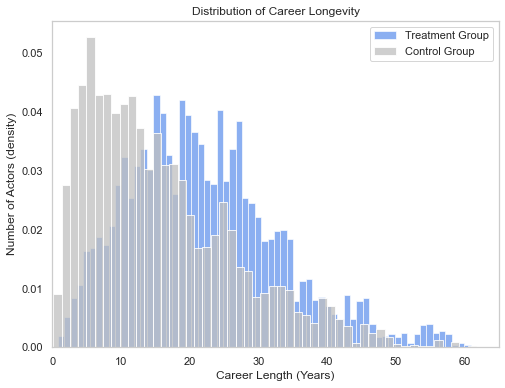

In [50]:
# Set the style
sns.set(style="whitegrid")

# Plot histograms
plt.figure(figsize=(8, 6))
plt.xlim([0, 65])
plt.grid(False)
sns.histplot(treatment_group['career_length_in_years'], color="cornflowerblue", label='Treatment Group', stat='density')
sns.histplot(control_group['career_length_in_years'], color="silver", label='Control Group', stat='density')

plt.title('Distribution of Career Longevity')
plt.xlabel('Career Length (Years)')
plt.ylabel('Number of Actors (density)')
plt.legend()
plt.show()

From the histogram, it appears that:

- Both distributions have a right-skewed shape, indicating that a larger number of actors have shorter careers, while fewer actors have very long careers.
- The Treatment Group (in blue) has a distribution that generally shows longer career lengths compared to the Control Group (in gray).
- As careers get longer, there are fewer actors in both groups, but the group of actors who were in a big hit consistently shows more actors at almost every career stage. This suggests that actors who've had a big hit generally enjoy longer careers.


Let's plot the box plot of this variable between these two groups

/var/folders/f0/cfcxfzqn0nv2yms8q65vtvc80000gn/T/ipykernel_52912/1867192777.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='career_length_in_years', data=data_combined, palette={"Treatment Group": "cornflowerblue", "Control Group": "silver"})


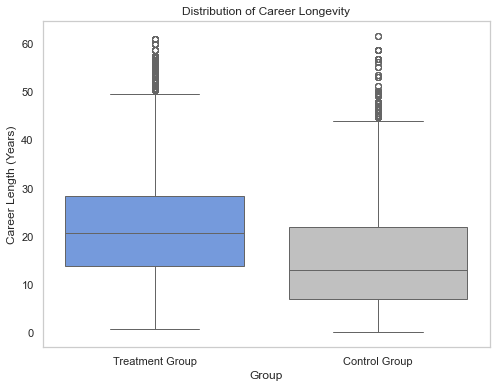

In [51]:
# Box plot

# Set the style
sns.set(style="whitegrid")

# Combine the data into a single DataFrame for plotting
data_combined = pd.concat([treatment_group.assign(Group="Treatment Group"),
                           control_group.assign(Group="Control Group")])

# Plot boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='career_length_in_years', data=data_combined, palette={"Treatment Group": "cornflowerblue", "Control Group": "silver"})
plt.grid(False)
plt.title('Distribution of Career Longevity')
plt.xlabel('Group')
plt.ylabel('Career Length (Years)')
plt.show()

From this boxplot, it appears that:

- The median for the Treatment Group's career lengths is above that of the Control Group, implying that, on average, actors in the Treatment Group enjoy longer careers.
- The spread of career lengths for the middle half of actors in the Treatment Group is higher up the scale, meaning that a typical actor in this group has a longer career than one in the Control Group.
- While both groups have some actors with very long careers, there are more in the Control Group than we might expect. This shows that some actors can still have long careers without starring in a big hit movie.


#### 4.1.2 Movie counts


#### A. Statiscal analysis

Next, we will look to the number of unique movieIDs associated with each actor to see if actors in big hits tend to appear in more movies overall

In [52]:
# Analysis standard deviation

# Calculate the std number of movies for the treatment group
std_movies_treatment = treatment_group['movie_count'].std()

# Calculate the std number of movies for the control group
std_movies_control = control_group['movie_count'].std()

print(f'Standard deviation of number of movies for actors in big hits: {std_movies_treatment: .2f}')
print(f'Standard deviation of number of movies for actors not in big hits: {std_movies_control: .2f}')

Standard deviation of number of movies for actors in big hits:  9.96
Standard deviation of number of movies for actors not in big hits:  4.61


In [53]:
# Analysis mean

# Calculate the average number of movies for the treatment group
average_movies_treatment = treatment_group['movie_count'].mean()

# Calculate the average number of movies for the control group
average_movies_control = control_group['movie_count'].mean()

print(f'Average number of movies for actors in big hits: {average_movies_treatment: .2f}')
print(f'Average number of movies for actors not in big hits: {average_movies_control: .2f}')


Average number of movies for actors in big hits:  16.54
Average number of movies for actors not in big hits:  7.27


As we proceeded for carrer longevity, we will perfor a two-sampled t-test to see if there is a difference in the mean between these two groups.

**Null Hypothesis(H0)**: There is no difference in the mean movie counts between the two groups

**Alternative Hypothesis(H1)**:  There is a difference in the mean movie counts between the two groups

Here, we see that the variances of the two groups are significantly different. We will use Welch's t-test to compare the means.

In [55]:
# By setting equal_var to False, we perform Welch’s t-test, which does not assume equal population variance
t_stat, p_value = ttest_ind(treatment_group['movie_count'], control_group['movie_count'], equal_var=False, alternative='greater')

print(f'{t_stat : .2f}, {p_value: .2f}')

 135.79,  0.00


The result of Welch's t-test suggests a significant difference between the two groups regarding their 'movie_count'. Since the p-value is reported as 0.0, it is actually a value that is too small to be represented by the floating-point precision in the output and is therefore considered to be extremely significant statistically.


We can conclude that actors in the treatment group are associated with a significantly different (likely higher, given the context) number of movie appearances compared to the control group, and this difference is not due to random chance according to the test's results

#### B. Plot

Let's create a boxplot to see how the number of movies is spread out between the two groups.

/var/folders/f0/cfcxfzqn0nv2yms8q65vtvc80000gn/T/ipykernel_52912/2703350203.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='movie_count', data=data_combined, palette={"Treatment Group": "cornflowerblue", "Control Group": "silver"})


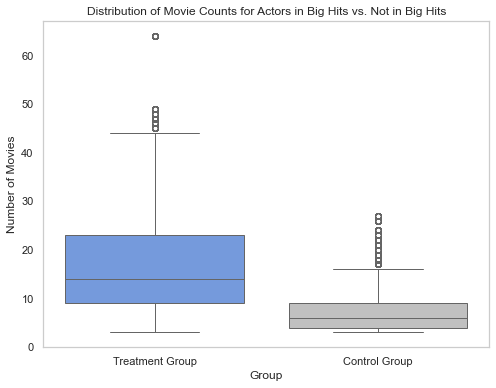

In [56]:

# Box plot

# Set the style
sns.set(style="whitegrid")

# Combine the data into a single DataFrame for plotting
data_combined = pd.concat([treatment_group.assign(Group="Treatment Group"),
                           control_group.assign(Group="Control Group")])

# Plot boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='movie_count', data=data_combined, palette={"Treatment Group": "cornflowerblue", "Control Group": "silver"})
plt.grid(False)
plt.xlabel('Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Counts for Actors in Big Hits vs. Not in Big Hits')
plt.show()

From this boxplot, it appears that:

- Actors in the Treatment Group typically appear in more movies, as indicated by the higher median (the line within the blue box).
- The interquartile range (IQR), which is the range between the first quartile (25th percentile) and the third quartile (75th percentile), is wider for the Treatment Group, suggesting more variability in the number of movies among actors in this group.
- The presence of more outliers in the Treatment Group with very high movie counts could indicate that actors who appear in big hits are more likely to have prolific careers.

#### 4.1.3 Age at peak


#### A. Statiscal analysis

Next, we will look to the number of age at peak with each actor to compare this with the two groups.

We define the **peak of one actor's carrier** by the year where the product of the number of movies played in with their respective success metric is the highest.

In [57]:
# Analysis standard deviation

# Calculate the std number of movies for the treatment group
std_age_treatment = treatment_group['age_at_peak'].std()

# Calculate the std number of movies for the control group
std_age_control = control_group['age_at_peak'].std()

print(f'Standard deviation of age at peak for actors in big hits: {std_age_treatment: .2f}')
print(f'Standard deviation of age at peak for actors not in big hits: {std_age_control: .2f}')

Standard deviation of age at peak for actors in big hits:  14.16
Standard deviation of age at peak for actors not in big hits:  14.61


In [58]:
# Analysis standard deviation

# Calculate the average number of movies for the treatment group
mean_age_treatment = treatment_group['age_at_peak'].mean()

# Calculate the average number of movies for the control group
mean_age_control = control_group['age_at_peak'].mean()

print(f'Mean of age at peak for actors in big hits: {mean_age_treatment: .2f}')
print(f'Mean of age at peak for actors not in big hits: {mean_age_control: .2f}')

Mean of age at peak for actors in big hits:  41.07
Mean of age at peak for actors not in big hits:  38.41


To determine if there is a significant difference in the mean of age at peak between actors who played in a big hit (treatment group) and those who did not (control group), we will use **hypothesis testing**.

**Null Hypothesis(H0)**: There is no difference in the mean of age at peak between the two groups

**Alternative Hypothesis(H1)**:  There is a difference in the mean of at peak between the two groups


For this we perform a t-testing assuming that the variance is the same since the difference is negligible.

In [60]:
t_stat, p_value = ttest_ind(treatment_group['age_at_peak'], control_group['age_at_peak'], alternative='greater')

print(f'{t_stat : .2f}, {p_value: .2f}')

 18.65,  0.00


The extremely low p-value indicates that the probability of observing such a large t-statistic under the null hypothesis (that there is no difference in means or that the mean age at peak of the treatment group is not greater than the control group) is close to zero. Therefore, we can reject the null hypothesis (at significance level .05) in favor of the alternative hypothesis that the mean age at peak of the treatment group is indeed greater than that of the control group with a high degree of confidence.



#### B. Plot

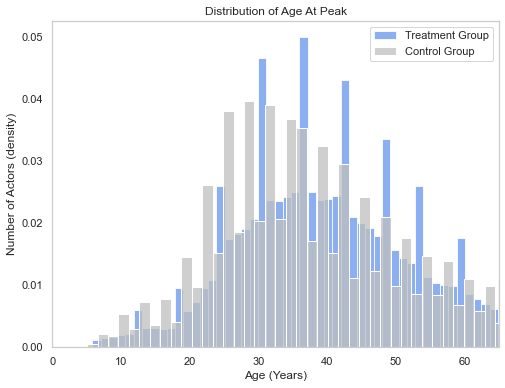

In [61]:
# Set the style
sns.set(style="whitegrid")

# Plot histograms
plt.figure(figsize=(8, 6))
plt.xlim([0, 65])
plt.grid(False)
sns.histplot(treatment_group['age_at_peak'], color="cornflowerblue", label='Treatment Group', stat='density')
sns.histplot(control_group['age_at_peak'], color="silver", label='Control Group', stat='density')

plt.title('Distribution of Age At Peak')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Actors (density)')
plt.legend()
plt.show()

From this histogram, it appears that:

- For both groups, there's a concentration of actors who reached their peak in their 30s and early 40s, which appears to be the most common age range for reaching a peak
- The Treatment Group has a higher density of actors who reached their peak at a younger age compared to the Control Group. This is particularly noticeable in the age range of about 25 to 35 years.

Combining this histogram with the earlier t-test results we provided, we can say that the Treatment Group not only has a significantly higher mean age at peak, but also the distribution of their peak ages tends to include a higher number of younger actors.

### 4.2 Carrer Post-big hit analysis

It is interesting to look at the evolution of the career of actors after their first big hit to see if we can notice any change with their career pre-big hit or with the career of an actor that did not play in a big hit.

#### Prepare the dataframe

We want compare the before/after big hit career of actors in the treatment group with the ones in the control group. To do so we have to define an event for the actors in the control group that will be used as reference to set the before/after career of those actors (since they did not play in any big hit movie). We decided to attribute a mock-up 'first big hit' to actors in the control group that corresponds to the movie number (ordered in chronological order) of first big hit of their respective matched treatment group actor. So for example, Lou Taylor Pucci is in the control group since he did not play in any big hit movies, he was matched with Leonardo DiCaprio who is in the treatment group. Leonardo DiCaprio had his first big hit after playing in 4 movies, it's 5th movie was his first big hit. Following this, we set the mock-up first big hit of Lou Taylor Pucci to be his 5th movie. In a sense this 'nth' movie represents the most likely movie for the first big hit of control group actors (if they had one).

First we want to use the matched dataframe to create a new column on our working dataframe. This column will contain, for each actor, the name of the actor that has been matched with them. 

In [62]:
# Keep only interesting columns for subsequent analysis
col = ['movieID', 'name_movie', 'releaseDate', 'genres',  'revenue', 'success', 'averageRating', 'is_movie_big_hit', 'name_actor',
       'birth', 'big_hit_actor', 'movie_count_before_hit', 'role_importance', 'comp_active', 'comp_pasive', 'comp_attribut']
df_career_analysis = df_movies_balanced[col].copy()

In [63]:
# Keep only name columns from the matched dataframe
matched_df = matched_df[['name_actor_control', 'name_actor_treat']]

# Create new column with the name of the matched actor (do this for treatment and control group):
# First populate our dataframe with the mached treatment actor names for the control group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_control', how='left')
df_career_analysis = df_career_analysis.drop(labels='name_actor_control', axis=1)
# Do the same for the treatment group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_treat', how='left', suffixes=('', '_merge'))
df_career_analysis = df_career_analysis.drop(labels='name_actor_treat_merge', axis=1)

# Merge the two columns to form only one (matched_name)
df_career_analysis['matched_name'] = df_career_analysis['name_actor_treat'].combine_first(df_career_analysis['name_actor_control'])
df_career_analysis = df_career_analysis.drop(labels=['name_actor_control', 'name_actor_treat'], axis=1)

Then we want to attribute to each control actor the same 'movie_count_before_hit' as the actor they have been matched with.

In [64]:
# Merge our dataframe (df_career_analysis) with a version of itself (only one row for each acotrs) based on 'matched_name'
df_for_merge = df_career_analysis.drop_duplicates(subset='name_actor')
merged_df = pd.merge(df_career_analysis, df_for_merge[['name_actor', 'movie_count_before_hit']],
                     left_on='matched_name',
                     right_on='name_actor',
                     how='left',
                     suffixes=('', '_matched'))

# Fill missing values in 'movie_count_before_hit' with values from the matched actor
df_career_analysis['movie_count_before_hit'] = df_career_analysis['movie_count_before_hit'].combine_first(merged_df['movie_count_before_hit_matched'])

Now, before going further, we will arrange the movies in a chronological order and assign a number representing the respective position (in the timeline) with respect to the first big-hit movie. This number is named 'n': n<0 if the movie was released before the first big-hit movie, n=0 is the movie is the first big-hit movie and n>0 if the movie was released after the first big-hit movie.

In [65]:
# Keep only name columns from the matched dataframe
matched_df = matched_df[['name_actor_control', 'name_actor_treat']]

# Create new column with the name of the matched actor (do this for treatment and control group):
# First populate our dataframe with the mached treatment actor names for the control group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_control', how='left')
df_career_analysis = df_career_analysis.drop(labels='name_actor_control', axis=1)
# Do the same for the treatment group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_treat', how='left', suffixes=('', '_merge'))
df_career_analysis = df_career_analysis.drop(labels='name_actor_treat_merge', axis=1)

# Merge the two columns to form only one (matched_name)
df_career_analysis['matched_name'] = df_career_analysis['name_actor_treat'].combine_first(df_career_analysis['name_actor_control'])
df_career_analysis = df_career_analysis.drop(labels=['name_actor_control', 'name_actor_treat'], axis=1)

Then we want to attribute to each control actor the same 'movie_count_before_hit' as the actor they have been matched with.

In [66]:
# Merge our dataframe (df_career_analysis) with a version of itself (only one row for each acotrs) based on 'matched_name'
df_for_merge = df_career_analysis.drop_duplicates(subset='name_actor')
merged_df = pd.merge(df_career_analysis, df_for_merge[['name_actor', 'movie_count_before_hit']],
                     left_on='matched_name',
                     right_on='name_actor',
                     how='left',
                     suffixes=('', '_matched'))

# Fill missing values in 'movie_count_before_hit' with values from the matched actor
df_career_analysis['movie_count_before_hit'] = df_career_analysis['movie_count_before_hit'].combine_first(merged_df['movie_count_before_hit_matched'])

Now, before going further, we will arrange the movies in a chronological order and assign a number representing the respective position (in the timeline) with respect to the first big hit movie. This number is named 'n': n<0 if the movie was released before the first big hit movie, n=0 is the movie is the first big hit movie and n>0 if the movie was released after the first big hit movie.

In [67]:
# Sort by actor name and order by release date and success (for actors that have movies with same release dates)
df_career_analysis = df_career_analysis.sort_values(by=['name_actor', 'releaseDate', 'success']).reset_index(drop=True)

# Group by actor names and apply the center_on_first_hit function to comptue 'n'
grp = df_career_analysis.groupby('name_actor')
df_career_analysis['n'] = grp.apply(lambda x: x.apply(lambda row: center_on_first_hit(x, row), axis=1)).reset_index(drop=True)

# Get rid of unwanted columns for upcoming analysis
df_career_analysis = df_career_analysis.drop(labels='movie_count_before_hit', axis=1)

#### 4.2.1 Revenue

Now that we have our arranged dataframe with the control group and the treatment group, we can look at their respective career evolution with respect to movie box office revenues, average IMDb ratings and success values.

One thing we have to care about is the representativity of the values we will plot. For this we have to make sure that, for both the treatment and the control group, we have enough values for each nth-movie plotted. We decided to keep only 'n' indexes for which we have more than 1000 values. 

In [68]:
# Seperate the control group and the treatement group
treat = df_career_analysis[df_career_analysis.big_hit_actor]
ctrl = df_career_analysis[~df_career_analysis.big_hit_actor]

# Get the number of actors we have for each year n
nb_of_actors_for_n_treat = treat.groupby('n')['name_actor'].count()
nb_of_actors_for_n_ctrl = ctrl.groupby('n')['name_actor'].count()

# Define the indexes we will keep where the number obf actors is representative enough
to_plot_indexes_treat = nb_of_actors_for_n_treat[nb_of_actors_for_n_treat.values>=1000].index
to_plot_indexes_ctrl = nb_of_actors_for_n_ctrl[nb_of_actors_for_n_ctrl.values>=1000].index

# Keep only indexes (n values) where we have enough actors (as computed above)
plot_treat = treat[treat.n.isin(to_plot_indexes_treat)]
plot_ctrl = ctrl[ctrl.n.isin(to_plot_indexes_ctrl)]

# Group by the 'n' value
treat_grp = plot_treat.groupby('n')
ctrl_grp = plot_ctrl.groupby('n')

We will start the analysis by looking at the mean movie box office revenue for each group. 

It is interesting to get a sense of how this variable is distributed among the two groups. For this we plot the revenue of the first movie after the first big hit.

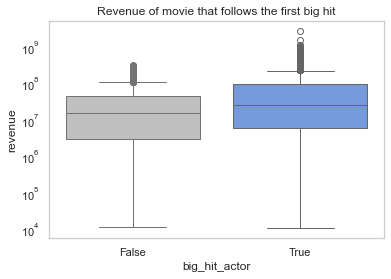

In [69]:
# Get the movies that follow the first big hit
first_after_hit_treat = treat[treat.n == 1]
first_after_hit_ctrl = ctrl[ctrl.n == 1]

# Plot the revenue
plt.title('Revenue of movie that follows the first big hit')
sns.boxplot(x='big_hit_actor', y='revenue', data=first_after_hit_ctrl, color='silver')
sns.boxplot(x='big_hit_actor', y='revenue', data=first_after_hit_treat, color='cornflowerblue')
# Plot in log scale to have better visibility 
plt.yscale('log')
plt.grid(False)
plt.show()

As we can see from this plot the revenue is not normally distributed and it contains many extreme outliers (not the log scale of the y-axis). It also seems that the treatment group revenue value is more skewed than for the control group. So when plotting the revenue for each 'n' we will rather use the median instead of the mean and quantiles instead of standard deviation.

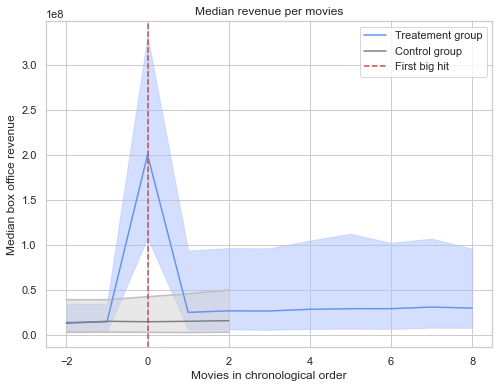

In [70]:
# Compute the mean revenue. Then keep only indexes for which we have enough actors
to_plot_rev_treat = treat_grp.revenue.median()
to_plot_rev_ctrl = ctrl_grp.revenue.median()

# Compute the 25th and 75th quantile for the revenue
Q75_treat = treat_grp.revenue.quantile(q=0.75)
Q25_treat = treat_grp.revenue.quantile(q=0.25)

Q75_ctrl = ctrl_grp.revenue.quantile(q=0.75)
Q25_ctrl = ctrl_grp.revenue.quantile(q=0.25)

# Plot the results
plt.figure(figsize=(8,6))
plt.fill_between(to_plot_rev_treat.index, Q25_treat, Q75_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_rev_ctrl.index, Q25_ctrl, Q75_ctrl, alpha = 0.5, color =  'lightgrey')

plt.plot(Q75_ctrl, color='silver')
plt.plot(Q25_ctrl, color='silver')

plt.plot(to_plot_rev_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_rev_ctrl, label = 'Control group', color='grey')

plt.axvline(x=0, color='r', label = 'First big hit', linestyle ='--')
plt.title('Median revenue per movies')
plt.xlabel('Movies in chronological order')
plt.ylabel('Median box office revenue')
plt.legend()
plt.show()

This graph shows the evolution of the median box office revenue along the movies arranged in chronological order. The uncertainty is represented using quantiles (the 25th and the 75th). 

We can see that the median is approximately the same for the two groups before the big hit event. For the big hit movie, as expected, the treatment group (for which the movie was an actual big hit) box office revenue median is much higher than the control group median. What is interesting to see is that, after this first big hit, the median does not fall back to its previous low value but sets, for the next couple of years, to a value that is a bit higher. 

However, there is a lot of variability in the revenue variable and the interquartile range of the treatment and the control group overlaps. This prevents us from having a clear cut and being able to make a strong statement about a difference in the two groups relying only on this graph. We can however see that amoung the treatment group there is a much wider and variable dirstribution of the movie revenue (as seen in the previous plot with the numerous high value outliers).

We will now perform a statistiacl test for the revenue of the movies that comes directly after the first big hit (n=1 and n=2) to see if the difference between the two groups revenue median is significant. However, we will not use a t-test because as we have see our data is not normally distributed and the standard deviation seems to be quite different. We will be using a Wilcoxon signed-rank test instead. One of the reason that we selected this test is that our data is matched.

**Null Hypothesis(H0)**: There is no difference in the median of the movie revenue between the two groups (for n={1, 2})

**Alternative Hypothesis(H1)**:  The median of the movie revenue is bigger for the treatement group than for the control group (for n={1, 2})

In [71]:
# Get subset with n = 1 
after_hit_treat_1 = treat[treat.n == 1]
after_hit_ctrl_1 = ctrl[ctrl.n == 1]

# Get subset with n = 2
after_hit_treat_2 = treat[treat.n == 2]
after_hit_ctrl_2 = ctrl[ctrl.n == 2]

In [72]:
# Perform one-sided Wilcoxon test for n=1
display(scipy.stats.wilcoxon(after_hit_treat_1.revenue, after_hit_ctrl_1.revenue, alternative='greater'))

WilcoxonResult(statistic=2522651.0, pvalue=2.4945913295810143e-41)

In [73]:
# Perform one-sided Wilcoxon test for n=2
display(scipy.stats.wilcoxon(after_hit_treat_2.revenue, after_hit_ctrl_2.revenue, alternative='greater'))

WilcoxonResult(statistic=2482183.5, pvalue=2.149710178680272e-36)

The two p-values of the Wilcoxon tests are well below 0.05 which means that we can reject the null hypothesis with statistical significance level .05. This implies that there is enough evidence in the data to conclude that there is a statistically significant difference (at 0.5 level) between the paired observations for the revenue value (of movies with n={1, 2}).

In [74]:
# Compute the median difference for n={1, 2}
diff_n1 = after_hit_treat_1.revenue.median()-after_hit_ctrl_1.revenue.median()
diff_n2 = after_hit_treat_2.revenue.median()-after_hit_ctrl_2.revenue.median()

# Print the result statement
print(f'The median revenue of movies in the treatment group was found to be significantly higher than that of the control group by ${diff_n1} for n=1 \
and by ${diff_n2} for n=2. This difference was determined to be statistically significant at the 0.05 level.')

The median revenue of movies in the treatment group was found to be significantly higher than that of the control group by $9882885.0 for n=1 and by $10911496.5 for n=2. This difference was determined to be statistically significant at the 0.05 level.


In conclusion, our analysis suggests that the movie revenue of actors after they played in their first big hit is higher than the movie revenue of actors that did not play in a big hit movie.

#### 4.2.2 IMDb average rating
Let's move on and do the same analysis for the average IMDb rating.

Same as before, we will first get a sense of how this variable is distributed among the two groups. For this we plot the average IMDb rating of the first movie after the first big hit.

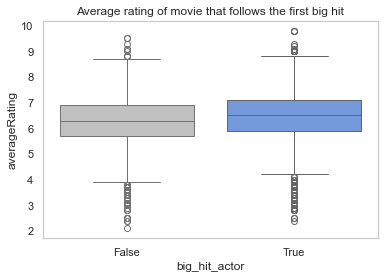

In [75]:
# Plot the average rating for the movie that follows the first big hit in chronological order
plt.title('Average rating of movie that follows the first big hit')
sns.boxplot(x='big_hit_actor', y='averageRating', data=first_after_hit_ctrl, color='silver')
sns.boxplot(x='big_hit_actor', y='averageRating', data=first_after_hit_treat, color='cornflowerblue')
plt.grid(False)
plt.show()

From this plot we can see that the average rating variable seems to be pretty much normally distributed. So we will be using the mean standard deviations for the upcoming plot.

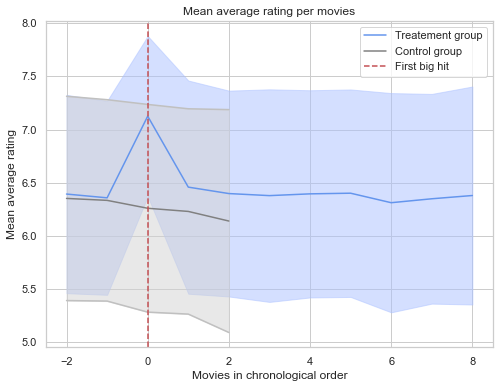

In [76]:
# Compute the mean IMDb rating. Then keep only indexes for which we have enough actors
to_plot_rating_treat = treat_grp.averageRating.mean()
to_plot_rating_ctrl = ctrl_grp.averageRating.mean()

# Do the same with the standard deviation
std_rating_treat = treat_grp.averageRating.std()
std_rating_ctrl = ctrl_grp.averageRating.std()

# Plot the results
plt.figure(figsize=(8,6))

plt.fill_between(to_plot_rating_treat.index, to_plot_rating_treat-std_rating_treat, to_plot_rating_treat+std_rating_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_rating_ctrl.index, to_plot_rating_ctrl - std_rating_ctrl, to_plot_rating_ctrl + std_rating_ctrl, alpha = 0.5, color =  'lightgrey')
plt.plot((to_plot_rating_ctrl - std_rating_ctrl), color='silver')
plt.plot((to_plot_rating_ctrl + std_rating_ctrl), color='silver')

plt.plot(to_plot_rating_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_rating_ctrl, label = 'Control group', color='grey')


plt.axvline(x=0, color='r', label = 'First big hit', linestyle ='--')
plt.title('Mean average rating per movies')
plt.xlabel('Movies in chronological order')
plt.ylabel('Mean average rating')
plt.legend()
plt.show()

This graph shows the evolution of the mean of the average IMDb rating along the movies when arranged in chronological order. The uncertainty is represented using the standard deviation. 

Similarly as with the revenue variable, we can see that the mean is approximately the same for the two groups before the big hit event. At the big hit movie, the treatment group (for which the movie was an actual big hit) IMDb rating mean rises (unsurprisingly) above the control group mean. After the big hit event, the mean of the control group returns to its previous value. This is in contrast with the control group mean which seems to decrease.

However, the means of the two groups are always quite close to one another (the difference in average rating is less than 1) and the two group's standard deviation strongly overlap. For this reason we cannot conclude that there is any difference between the two groups. It would be interesting to have more data for the control group to know if the average rating tendency to drop actually continues or if it is only random data variation.

#### 4.2.3 Success
Let's now continue our analysis by looking at the success value.

Again, we will first get a sense of how this variable is distributed among the two groups. For this we plot the success value of the first movie after the first big hit.

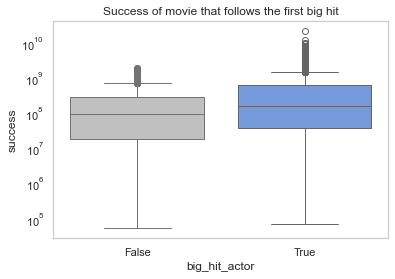

In [77]:
# Plot the average rating for the movie that follows the first big hit in chronological order
plt.title('Success of movie that follows the first big hit')
sns.boxplot(x='big_hit_actor', y='success', data=first_after_hit_ctrl, color='silver')
sns.boxplot(x='big_hit_actor', y='success', data=first_after_hit_treat, color='cornflowerblue')
# Plot in log scale to have better visibility 
plt.yscale('log')
plt.grid(False)
plt.show()

As we can see from this plot the success value is not normally distributed and it contains many extreme outliers (note log scale of the y-axis). It also seems that the treatment group success value is more skewed than for the control group. So when plotting the revenue for each 'n' we will rather use the median instead of the mean and quantiles instead of standard deviation.

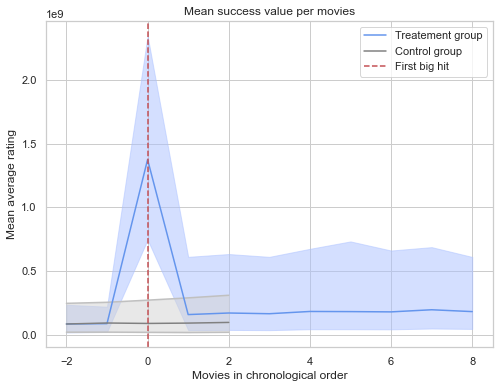

In [78]:
# Compute the mean success value. Then keep only indexes for which we have enough actors
to_plot_success_treat = treat_grp.success.median()[to_plot_indexes_treat]
to_plot_success_ctrl = ctrl_grp.success.median()[to_plot_indexes_ctrl]

# Compute the 25th and 75th quantile for the success value
Q75_treat = treat_grp.success.quantile(q=0.75)
Q25_treat = treat_grp.success.quantile(q=0.25)

Q75_ctrl = ctrl_grp.success.quantile(q=0.75)
Q25_ctrl = ctrl_grp.success.quantile(q=0.25)

# Plot the results
plt.figure(figsize=(8,6))
plt.fill_between(to_plot_success_treat.index, Q25_treat, Q75_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_success_ctrl.index, Q25_ctrl, Q75_ctrl, alpha = 0.5, color =  'lightgrey')

plt.plot(Q25_ctrl, color='silver')
plt.plot(Q75_ctrl, color='silver')

plt.plot(to_plot_success_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_success_ctrl, label = 'Control group', color='grey')


plt.axvline(x=0, color='r', label = 'First big hit', linestyle ='--')
plt.title('Mean success value per movies')
plt.xlabel('Movies in chronological order')
plt.ylabel('Mean average rating')
plt.legend()
plt.show()

This graph shows the evolution of the median success value along the movies arranged in chronological order. The uncertainty is represented using quantiles (the 25th and the 75th). 

This graph is very similar to the one from the analysis of the revenue evolution. We can also notice that the median is approximately the same for the two groups before the big hit event. For the big hit movie, as expected, the treatment group median success value is much higher than the control group median. Similarly as for the revenue and the IMDb rating analysis we observe that, after this first big hit, the median does not fall back to its previous low value but sets, for the next couple of years, to a value that is a bit higher. 

However, the two medians are close to one another even after the big hit event. Moreover there is a lot of variability in the two groups (especially in the treatment group) and their interquartile range overlaps. This prevents us from having a clear cut and being able to make a strong statement about a difference in the two groups relying only on this graph. We can however see that among the treatment group there is a much wider and variable distribution of the movie revenue (as seen in the previous plot with the numerous high-value outliers).

We will now perform a statistical test for the revenue of the movies that comes directly after the first big hit (n=1 and n=2) to see if the difference between the two groups' success median is significant. However, we will not use a t-test because as we have seen our data is not normally distributed and the standard deviation seems to be quite different. We will be using a Wilcoxon signed-rank test instead. One of the reasons that we selected this test is that our data is mached.


**Null Hypothesis(H0)**: There is no difference in the median of the movie success value between the two groups (for n={1, 2})

**Alternative Hypothesis(H1)**:  The median of the movie success value is bigger for the treatement group than for the control group (for n={1, 2})

In [79]:
## Perform one-sided Wilcoxon test for n=1
display(scipy.stats.wilcoxon(after_hit_treat_1.success, after_hit_ctrl_1.success, alternative='greater'))

WilcoxonResult(statistic=2541043.0, pvalue=6.74624599838967e-44)

In [80]:
# Perform one-sided Wilcoxon test for n=2
display(scipy.stats.wilcoxon(after_hit_treat_2.revenue, after_hit_ctrl_2.revenue, alternative='greater'))

WilcoxonResult(statistic=2482183.5, pvalue=2.149710178680272e-36)

The two p-values of the Wilcoxon tests are well below 0.05 which means that we can reject the null hypothesis with statistical significance level .05. This implies that there is enough evidence in the data to conclude that there is a statistically significant difference (at 0.5 level) between the paired observations for the success value (of movies with n={1, 2}).

In [81]:
# Compute the median difference for n={1, 2}
diff_n1 = after_hit_treat_1.success.median()-after_hit_ctrl_1.success.median()
diff_n2 = after_hit_treat_2.success.median()-after_hit_ctrl_2.success.median()

# Print the result statement
print(f'The median success value of movies in the treatment group was found to be significantly higher than that of the control group by {diff_n1:.2f} \
for n=1 and by {diff_n2:.2f} for n=2. This difference was determined to be statistically significant at the 0.05 level.')

The median success value of movies in the treatment group was found to be significantly higher than that of the control group by 66886986.65 for n=1 and by 73837455.75 for n=2. This difference was determined to be statistically significant at the 0.05 level.


In conclusion, our analysis suggests that the movie success value of actors after they played in their first big hit is higher than the movie success value of actors that did not play in a big hit movie.

Out of curiosity let's have a look at those actors who played in multiple outlier big hit movies (with respecto to success).

In [82]:
# Merge Q75_treat_reset with plot_treat to associate the Q75 values with the actors and n values
merged_data = pd.merge(plot_treat, Q75_treat, on=['n'], how='left', suffixes=('', '_q75'))

# Create a mask for filtering
mask = merged_data['success'] > merged_data['success_q75']

# Use the mask to filter the original DataFrame
filtered_data = merged_data[mask]

# Print the names of the actors that have often played in an outlier big hit movie (with respect to success)
filtered_data.groupby('name_actor').movieID.count().sort_values(ascending=False)[0:10]

name_actor
Seth Rogen           10
Kevin James           9
Christopher Lee       8
Julie Walters         8
Sacha Baron Cohen     8
Ian McShane           8
Hugo Weaving          8
Bill Nighy            8
Conrad Vernon         8
Orlando Bloom         8
Name: movieID, dtype: int64

In the top of this list we find actors that play in general public blockbusters comedies (such as Kevin James and Seth Rogensuch). We also find actors that played in blockbuster series such as Harry Potter (Tom Felton) and Pirates of the Caribbean (Orlando Bloom).

#### 4.2.3 Genres
Now let's look at the genres of the different movies actors played in and how they change from one movie to another.

We first have to convert the genre column from strings to bags of words. For this we first use the function we defined in helpers called parse_genres which safely parses the genres string and extracts genre names. We then use the Counter function from collections library to finally end up with bags of words.

In [83]:
# Compute the number of movies that do not have any genre value to assess the amount of missing information
nb_movies_no_genre = df_career_analysis[df_career_analysis['genres'] == '{}'].movieID.nunique()

# Use the parse_genres function defined in helpers file to parse strings and extract genre names
df_career_analysis['parsed_genres'] = df_career_analysis['genres'].apply(parse_genres)

# For the gernes column, replace the list by a bag of words using the Counter function
df_career_analysis['genres'] = df_career_analysis.parsed_genres.apply(lambda x: Counter(x))

# Get rid of unwanted column
df_career_analysis = df_career_analysis.drop(labels='parsed_genres', axis=1)

# Print the number of movies lost
print(f'The number of movies that have no information on genre is: {nb_movies_no_genre}, this represents \
{nb_movies_no_genre*100/df_career_analysis.movieID.nunique(): .2f}% of the movies. For those movies the genre was set to "No genre"')

The number of movies that have no information on genre is: 1, this represents  0.02% of the movies. For those movies the genre was set to "No genre"


There is only one movie for which we do not have genre data. Since this represents only a small fraction of the movies we have, we can ignore this and carry on with our analysis.

Now we want to compare different genre bag of words. To do so we must define a similarity function to use. The different movies have different level of genre description; some are short bag of words (e.g. {Drama: 1}), some are medium-length bag of words (e.g. {Drama: 1, Romance: 1}), and some are longer bag of words (e.g. {Drama: 1, Horror: 1, War film: 1}). But all three previous bag of words should have the same similarity since they all have only one genre in common and nothing else. Following this reasoning we decided to compute the similarity by simply counting the number of words that are the same in the two bag of words that we are comparing, without penalizing their length. The function that takes care of this is called 'dotproduct_similarity' and can be found in the helpers file

We still have to decide which pair of movies we will compare for our analysis. For each movie, we decided to compute the similarity with the two previous movies (in chronological order) and keep the mean value: similarity value for movie[n] = 0.5*(similarity(movie[n], movie[n-1]) + similarity(movie[n], movie[n-2])). 

In [84]:
# Group our dataframe by the names of the actors
grp = df_career_analysis.groupby('name_actor')

# Compute the similarity of the genres of each movie with the genres of the two movies that come before in chronological order
df_career_analysis['similarity'] = grp.apply(lambda x: x.apply(
    lambda row: similarity_two_prev_movie(x, row), axis=1)).reset_index(drop=True)
df_career_analysis['similarity'] = df_career_analysis['similarity'].astype(float)

Now that we have calculated the similarity values we can plot them. We will use boxplots to have a good representation of the variable distribution.

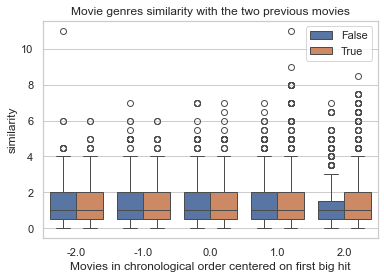

In [85]:
# Plot the boxplots for each representative n index
df_career_analysis_plot = df_career_analysis[df_career_analysis.n.isin(to_plot_indexes_ctrl)]
sns.boxplot(df_career_analysis_plot, x='n', y='similarity', hue='big_hit_actor')
plt.title('Movie genres similarity with the two previous movies')
plt.xlabel('Movies in chronological order centered on first big hit')
plt.legend()
plt.show()

As we can clearly see from this graph there is no real difference between the treatment and control group for the similarity between genres of successive movies played by an actor. Furthermore, we cannot notice a strong difference between before and after the first big hit event.

#### 4.2.4 Role

We will now focus on the data generated in the npl part of the notebook. We will first look at the role importance and its evolution before and after the big hit event. Then we will look at the evolution of the actor role compounds (active, passive, attribute) similarity of each n movie with the two previous movies.

#### Role importance
As there as many NaNs for the role importance values we first have to filter out, for each n, the actors that are concerned by this lack of data. But we also have to remove (for the n of concern) their respective matched pair. 

In addition, as we did in previous analysis, we keep only the nth movies for which we have enough data (at least 1000 values).

In [86]:
df_career_analysis.columns

Index(['movieID', 'name_movie', 'releaseDate', 'genres', 'revenue', 'success',
       'averageRating', 'is_movie_big_hit', 'name_actor', 'birth',
       'big_hit_actor', 'role_importance', 'comp_active', 'comp_pasive',
       'comp_attribut', 'matched_name', 'n', 'similarity'],
      dtype='object')

In [87]:
# Seperate the control and treatment group
treat = df_career_analysis[df_career_analysis.big_hit_actor]
ctrl = df_career_analysis[~df_career_analysis.big_hit_actor]

# Group by variable n
treat_grp = treat.groupby('n')
ctrl_grp = ctrl.groupby('n')

# Compute the index that have enough role_iportance values to be significant
n_to_plot_treat = treat_grp.role_importance.count()[treat_grp.role_importance.count()>1000].index
n_to_plot_ctrl = ctrl_grp.role_importance.count()[ctrl_grp.role_importance.count()>1000].index

# Keep the same index for the control and the treatment group (which ever has less index so have both groups for each plotted n)
if len(n_to_plot_treat) < len(n_to_plot_ctrl):
    n_to_plot = n_to_plot_treat
else: n_to_plot = n_to_plot_ctrl

# Make a copy of the current dataframe and keep only relevant indexes
df_with_role = df_career_analysis.copy()
df_with_role = df_with_role[df_with_role.n.isin(n_to_plot)]

# Remove for each n the actors and their matched pair for which we do not have information of role importance
for i in n_to_plot:
    df_i = df_career_analysis[df_career_analysis.n == i]
    list_actor_no_data_ni = df_i[df_i.role_importance.isna()].name_actor.unique()
    list_matched_no_data_ni = df_i[df_i.name_actor.isin(list_actor_no_data_ni)].matched_name.unique()
    tot_list_no_data_ni = list_actor_no_data_ni+list_matched_no_data_ni
    df_with_role = df_with_role[~((df_with_role.n==i) & (df_with_role.name_actor.isin(tot_list_no_data_ni)))]

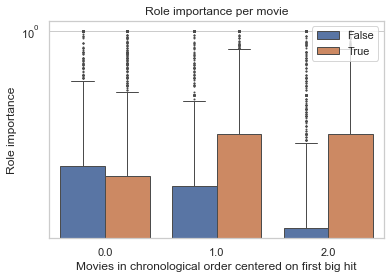

In [88]:
# Plot the boxplots for each representative n index
sns.boxplot(df_with_role, x='n', y='role_importance', hue='big_hit_actor', fliersize=1)
plt.title('Role importance per movie')
plt.xlabel('Movies in chronological order centered on first big hit')
plt.ylabel('Role importance')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

From this graph we can see that most of the role importance values are equal to zero or very close to zero (note the y-axis log scale). This is because the movie summaries are quite short and lack precision. However, we can still see that in general the big hit actors seem to have a wider and more skewed distribution (toward high values) for the role importance. In addition, we see the distribution of the role importance for the control group is narrowing down to zero movie after movie. In conclusion, this graph tells us that for our dataset, more actors that are in the treatement group recieved important roles than actors in the control group.

#### Role compound similarity

We will now look at the evolution of the role compound of the actors thoughout the movies they played in. Similarly as with the role importance we remove the NaN values by filtering out, for each n, the actors that are concerned by this lack of data and by also removing (for the n of concern) their respective matched pair.

The role compound is a vector including all three types of compound ('comp_active', 'comp_pasive', 'comp_attribut') so we have to create a new column named 'comp' with this value. Then we computed the similarity variable 'similarity_comp' by using a cosine similarity function and computing, for each actor role, the similarity with the two previous roles the actor had.

In [89]:
# Create new column with compound ('comp') variable
df_career_analysis['comp'] = df_career_analysis.apply(lambda row: np.array([row['comp_active'], row['comp_pasive'], row['comp_attribut']]), axis=1)

In [90]:
# Seperate the control and treatment group
treat = df_career_analysis[df_career_analysis.big_hit_actor]
ctrl = df_career_analysis[~df_career_analysis.big_hit_actor]

# Group by variable n
treat_grp = treat.groupby('n')
ctrl_grp = ctrl.groupby('n')

# Compute the index that have enough compound values to be significant
n_to_plot_treat = treat_grp.comp.count()[treat_grp.comp.count()>1000].index
n_to_plot_ctrl = ctrl_grp.comp.count()[ctrl_grp.comp.count()>1000].index

# Keep the same index for the control and the treatment group (which ever has less index so have both groups for each plotted n)
if len(n_to_plot_treat) < len(n_to_plot_ctrl):
    n_to_plot = n_to_plot_treat
else: n_to_plot = n_to_plot_ctrl

# Make a copy of the current dataframe and keep only relevant indexes
df_with_comp = df_career_analysis.copy()
df_with_comp = df_with_comp[df_with_comp.n.isin(n_to_plot)]

# Remove for each n the actors and their matched pair for which we do not have information of compound values
for i in n_to_plot:
    df_i = df_career_analysis[df_career_analysis.n == i]
    list_actor_no_data_ni = df_i[df_i.comp.isna()].name_actor.unique()
    list_matched_no_data_ni = df_i[df_i.name_actor.isin(list_actor_no_data_ni)].matched_name.unique()
    tot_list_no_data_ni = list_actor_no_data_ni+list_matched_no_data_ni
    df_with_comp = df_with_comp[~((df_with_comp.n==i) & (df_with_comp.name_actor.isin(tot_list_no_data_ni)))]


# Group our dataframe by the names of the actors
grp = df_with_comp.groupby('name_actor')

# Compute the similarity of the compound values of each movie with the compound values of the two movies that come before in chronological order
df_with_comp['similarity_comp'] = grp.apply(lambda x: x.apply(
     lambda row: similarity_two_prev_comp(x, row), axis=1)).reset_index(drop=True)

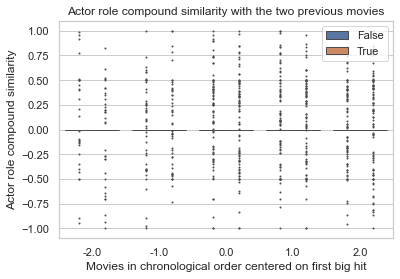

In [91]:
# Plot the boxplots for each representative n index
sns.boxplot(df_with_comp, x='n', y='similarity_comp', hue='big_hit_actor', fliersize=1)
plt.title('Actor role compound similarity with the two previous movies')
plt.xlabel('Movies in chronological order centered on first big hit')
plt.ylabel('Actor role compound similarity')
plt.legend(loc='upper right')
#plt.yscale('log')
plt.show()

In this plot we look at the evolution of the role compound similarity through the movies ordered in chronological order. The problem is that the large majority of the compound values are equal to zero because most of the words in the summaries are neutral and because the movie summaries are quite short. This translates into compound similarities that have value zero. As we can see from this plot, all values that are not zero are considered to be outliers (because almost all other values are zero). For these reasons we cannot conclude anything from this plot.